In [1]:
%matplotlib inline

from datetime import datetime
from scipy.optimize import minimize
from io import BytesIO
from pandas_datareader.data import DataReader
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf
import yfinance as yf
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# what is a regime switching model?

Traditional time series models assume that one set of model parameters can be used to describe the behavior of the data over all time. This assumption isn't always valid for what we encounter in real-world data.

Real-world time series data may have different characteristics, such as means and variances, across different time periods. Regime-switching models

A Markov process is a stochastic process where the possibility of switching to another state depends only on the current state of the model by the current state's probability distribution (it is usually represented by a state transition matrix). It is history-independent, or memoryless. 

Characterize data as falling into different, recurring “regimes” or “states”.
Allow the characteristics of time series data, including means, variances, and model parameters to change across regimes.
Assume that at any given time period there is a probability that the series may be in any of the regimes and may transition to a different regime.

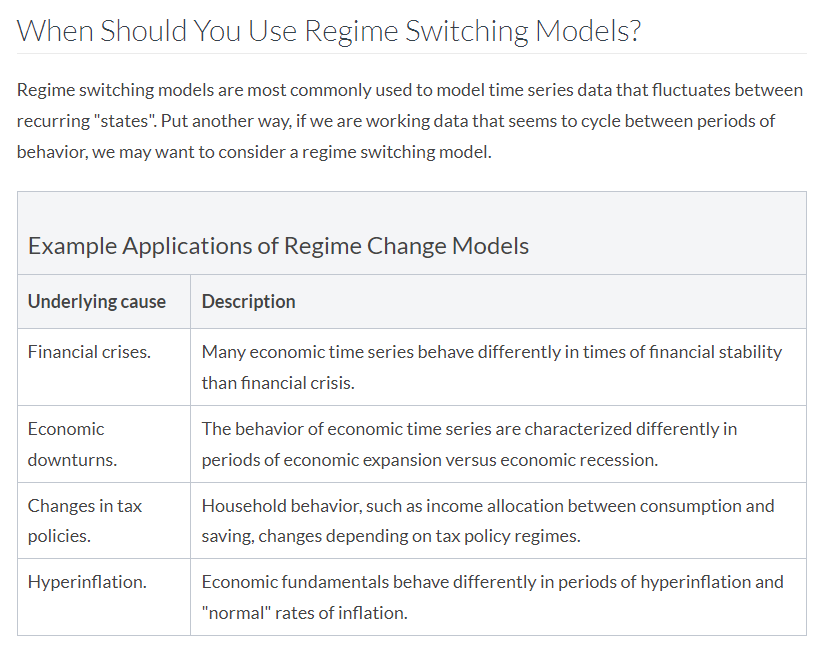

The Markov-switching model is a popular type of regime-switching model which assumes that unobserved states are determined by an underlying stochastic process known as a Markov-chain.

A Markov-chain is a stochastic process used to describe how uncertain and unobserved outcomes occur. In the case of the Markov-switching model, it is used to describe how data falls into unobserved regimes. A Markov-chain has the property that future states are dependent only on present states (this is known as the Markov property).

A key characteristic of a Markov-chain is the transition probabilities. The transition probabilities describe the likelihood that the current regime stays the same or changes (i.e the probability that the regime transitions to another regime).

The Components of the Markov-Switching Model
The complete Markov-switching model includes:

An assumed number of regimes.
A dependent variable.
Independent variables.
Parameters relating the dependent variable to the independent variables for each regime.
Transition probabilities.
Statistical inferences on the model parameters and the determined states.





# <font color = "blue"> 1) Data Wrangling & Preparing the 36 tradable instruments universe

In [2]:
# size (market cap) is the big picture binary segmentation:
### then the subsegmentation is done via high-low for 9 other factors:
    ### a) Valuation related factors: BM, CF/P, D/P, E/P, OP, 
    ### b) Change in investment: Investment
    ### c) Momentum related factors: 12-1Mom, prior month ret mom, 60-13 mom

In [3]:
# Book-to-Market ratio data
bm_v = pd.read_csv('6_Portfolios_BM_2x3.CSV', skiprows=15, nrows=1161, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
bm_e = pd.read_csv('6_Portfolios_BM_2x3.CSV', skiprows=1180, nrows=1161, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))

# Cashflow-to-Price ratio data
cfp_v = pd.read_csv('6_Portfolios_ME_CFP_2x3.CSV', skiprows=19, nrows=861, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
cfp_e = pd.read_csv('6_Portfolios_ME_CFP_2x3.CSV', skiprows=884, nrows=861, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))

# Dividend Yield data
dp_v = pd.read_csv('6_Portfolios_ME_DP_2x3.CSV', skiprows=19, nrows=1149, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
dp_e = pd.read_csv('6_Portfolios_ME_DP_2x3.CSV', skiprows=1172, nrows=1149, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))

# Earnings-to-Price ratio data
ep_v = pd.read_csv('6_Portfolios_ME_EP_2x3.CSV', skiprows=19, nrows=861, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
ep_e = pd.read_csv('6_Portfolios_ME_EP_2x3.CSV', skiprows=884, nrows=861, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))

# Operating Porfitability data
op_v = pd.read_csv('6_Portfolios_ME_OP_2x3.CSV', skiprows=22, nrows=717, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'), encoding='latin-1')
op_e = pd.read_csv('6_Portfolios_ME_OP_2x3.CSV', skiprows=743, nrows=717, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'), encoding='latin-1')

# 12-1 price momentum
smom_v = pd.read_csv('6_Portfolios_ME_Prior_12_2.CSV', skiprows=11, nrows=1155, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'), encoding='utf-8')
smom_e = pd.read_csv('6_Portfolios_ME_Prior_12_2.CSV', skiprows=1170, nrows=1155, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'), encoding='utf-8')


reorder = lambda x: x[[x.columns[2],x.columns[1],x.columns[0],x.columns[5],x.columns[4],x.columns[3]]]

# Investment data
inv_v = pd.read_csv('6_Portfolios_ME_INV_2x3.CSV', skiprows=16, nrows=717, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
inv_e = pd.read_csv('6_Portfolios_ME_INV_2x3.CSV', skiprows=737, nrows=717, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
inv_v, inv_e = reorder(inv_v), reorder(inv_e)

# Prior month return data
prior_v = pd.read_csv('6_Portfolios_ME_Prior_1_0.CSV', skiprows=11, nrows=1166, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'), encoding='utf-8')
prior_e = pd.read_csv('6_Portfolios_ME_Prior_1_0.CSV', skiprows=1181, nrows=1166, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'), encoding='utf-8')
prior_v, prior_e = reorder(prior_v), reorder(prior_e)

# 60-13 price momemtum
lmom_v = pd.read_csv('6_Portfolios_ME_Prior_60_13.CSV', skiprows=11, nrows=1107, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'), encoding='utf-8')
lmom_e = pd.read_csv('6_Portfolios_ME_Prior_60_13.CSV', skiprows=1122, nrows=1107, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'), encoding='utf-8')
lmom_v, lmom_e = reorder(lmom_v), reorder(lmom_e)

In [4]:
def long_short_data(x,y,title):
    time_series_1 = pd.DataFrame({title + '-B-v': r(x.iloc[:,5],x.iloc[:,3]), title + '-S-v': r(x.iloc[:,2],x.iloc[:,0])}) # low minus high
    time_series_2 = pd.DataFrame({title + '-B-e': r(y.iloc[:,5],y.iloc[:,3]), title + '-S-e': r(y.iloc[:,2],y.iloc[:,0])})
    return time_series_1, time_series_2

In [5]:
# synchronizing every time series to start at the same date (the time series with the latest start date)
v_data = [bm_v, cfp_v, dp_v, ep_v, op_v, inv_v, prior_v, smom_v, lmom_v]
latest_start_val = max([v_data[i].index[0] for i in range(9)])
v_data = [v_data[i][v_data[i].index.get_loc(latest_start_val):] for i in range(9)]

e_data = [bm_e, cfp_e, dp_e, ep_e, op_e, inv_e, prior_e, smom_e, lmom_e]
latest_start_eq = max([e_data[i].index[0] for i in range(9)]) # find the time series with the latest date
e_data = [e_data[i][e_data[i].index.get_loc(latest_start_eq):] for i in range(9)]

factor_title = ['Book_to_Market', 'Cashflow_to_Price', 'Dividend_Yield', 'Earning_to_Price','Operating_Profitability', 'Investment', 'Prior_Month_Return', '12_1_Momentum', '60_13_Momentum']
f = lambda x, y: (x - y).cumsum() # cumulative sum
r = lambda x, y: (x - y)
sns.set_context('talk')

In [6]:
BMv, BMe = long_short_data(v_data[0], e_data[0], factor_title[0]) #
CPv, CPe = long_short_data(v_data[1], e_data[1], factor_title[1])
DPv, DPe = long_short_data(v_data[2], e_data[2], factor_title[2])
EPv, EPe = long_short_data(v_data[3], e_data[3], factor_title[3])
OPv, OPe = long_short_data(v_data[4], e_data[4], factor_title[4])
INv, INe = long_short_data(v_data[5], e_data[5], factor_title[5])
PRv, PRe = long_short_data(v_data[6], e_data[6], factor_title[6])
SMv, SMe = long_short_data(v_data[7], e_data[7], factor_title[7])
LMv, LMe = long_short_data(v_data[8], e_data[8], factor_title[8])

In [7]:
BMv

,Book_to_Market-B-v,Book_to_Market-S-v
1963-07-01,-1.8143,-0.1242
1963-08-01,2.3484,1.2425
1963-09-01,-0.7856,1.0389
1963-10-01,-1.7112,1.5143
1963-11-01,0.9321,2.5673
...,...,...
2022-11-01,-0.2919,3.0592
2022-12-01,2.2289,0.4134
2023-01-01,-2.3248,-5.7714
2023-02-01,-2.3279,0.7586


In [8]:
BMv, BMe = BMv/100, BMe/100
CPv, CPe = CPv/100, CPe/100
DPv, DPe = DPv/100, DPe/100
EPv, EPe = EPv/100, EPe/100
OPv, OPe = OPv/100, OPe/100
INv, INe = INv/100, INe/100
PRv, PRe = PRv/100, PRe/100
SMv, SMe = SMv/100, SMe/100
LMv, LMe = LMv/100, LMe/100

In [9]:
SMv

,12_1_Momentum-B-v,12_1_Momentum-S-v
1963-07-01,0.0153,0.0026
1963-08-01,-0.0024,0.0227
1963-09-01,-0.0021,0.0060
1963-10-01,0.0376,0.0247
1963-11-01,-0.0239,0.0091
...,...,...
2022-11-01,-0.0458,0.0056
2022-12-01,0.0679,0.0225
2023-01-01,-0.1814,-0.1382
2023-02-01,-0.0264,0.0305


In [10]:
len(BMv.loc["1998-07-01":] )*0.20

59.400000000000006

In [11]:
len(BMv.loc["1998-07-01":] )*0.4

118.80000000000001

In [12]:
BMv.iloc[-119]

Book_to_Market-B-v    0.050818
Book_to_Market-S-v    0.001809
Name: 2013-05-01 00:00:00, dtype: float64

In [13]:
len(BMv.loc["2013-05-01":]) #start of validation set period 

119

In [14]:
BMv.iloc[-59]

Book_to_Market-B-v   -0.041027
Book_to_Market-S-v   -0.022589
Name: 2018-05-01 00:00:00, dtype: float64

In [15]:
len(BMv.loc["2018-05-01":]) #start of testing set period 

59

In [16]:
# fama french data factors
fafr5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, nrows=718, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
fafr5

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2022-12-01,-6.41,-0.16,1.32,0.09,4.19,0.33
2023-01-01,6.65,4.43,-4.05,-2.62,-4.53,0.35
2023-02-01,-2.58,0.69,-0.78,0.90,-1.41,0.34
2023-03-01,2.51,-7.01,-9.01,1.92,-2.29,0.36


In [17]:
rfr = fafr5["RF"]/100
rfr 

1963-07-01    0.0027
1963-08-01    0.0025
1963-09-01    0.0027
1963-10-01    0.0029
1963-11-01    0.0027
               ...  
2022-12-01    0.0033
2023-01-01    0.0035
2023-02-01    0.0034
2023-03-01    0.0036
2023-04-01    0.0035
Name: RF, Length: 718, dtype: float64

In [18]:
DFF = pd.read_csv("DFF.csv").set_index("DATE")
DFF.index = pd.to_datetime(DFF.index)
DFF = DFF.resample('d').asfreq().ffill()
DFF = DFF["DFF"] 
DFF = DFF[DFF.index.isin(BMv.index)]
DFF

DATE
1990-01-01    7.97
1990-02-01    8.54
1990-03-01    8.37
1990-04-01    8.29
1990-05-01    8.20
              ... 
2022-11-01    0.08
2022-12-01    0.08
2023-01-01    4.33
2023-02-01    4.33
2023-03-01    4.33
Name: DFF, Length: 399, dtype: float64

In [19]:
oilprc = pd.read_csv("WTIoil.csv").set_index("DATE")
oilprc.columns = ["WTI"]
oilprc["WTI"] = oilprc["WTI"].replace(".", np.nan).ffill()
oilprc.index = pd.to_datetime(oilprc.index)
oilprc = oilprc.resample('d').asfreq().ffill()
oilprc = oilprc[oilprc.index.isin(BMv.index)]
oilprc = oilprc["WTI"]
oilprc = pd.to_numeric(oilprc)
oilprc

DATE
1990-02-01    22.88
1990-03-01    23.81
1990-04-01    23.41
1990-05-01    23.07
1990-06-01    17.47
              ...  
2022-11-01    81.17
2022-12-01    82.51
2023-01-01    80.16
2023-02-01    80.16
2023-03-01    76.87
Name: WTI, Length: 398, dtype: float64

In [20]:
def get_priceret(ticker, start, end):
    data = yf.download(ticker,interval = '1d',
                     start = start + pd.Timedelta(1,'d'),
                     end = end + pd.Timedelta(1,'d')
                    )
    data1 = data.resample('d').asfreq().ffill()
    data1 = data1["Close"] 
    data1 = data1[data1.index.isin(BMv.index)]
    data_ret = data1.pct_change().bfill()
    
    return data_ret 

In [21]:
def get_pricelevel(ticker, start, end):
    data = yf.download(ticker,interval = '1d',
                     start = start + pd.Timedelta(1,'d'),
                     end = end + pd.Timedelta(1,'d')
                    )
    data1 = data.resample('d').asfreq().ffill()
    data1 = data1["Close"] 
    data1 = data1[data1.index.isin(BMv.index)]
    data_ret = data1.bfill()
    
    return data_ret 

In [22]:
SPY_ret = get_priceret("^SPX", dt.datetime(1993, 2, 1), dt.datetime(2023, 3, 1))
SPY_ret

[*********************100%***********************]  1 of 1 completed


Date
1993-02-01   -0.001152
1993-03-01   -0.001152
1993-04-01    0.018755
1993-05-01   -0.022452
1993-06-01    0.030987
                ...   
2022-11-01    0.075435
2022-12-01    0.057174
2023-01-01   -0.058154
2023-02-01    0.072851
2023-03-01   -0.040741
Name: Close, Length: 362, dtype: float64

In [23]:
(1+SPY_ret).cumprod() #cummulative simple returns methodology

Date
1993-02-01    0.998848
1993-03-01    0.997696
1993-04-01    1.016408
1993-05-01    0.993588
1993-06-01    1.024376
                ...   
2022-11-01    8.703915
2022-12-01    9.201555
2023-01-01    8.666445
2023-02-01    9.297801
2023-03-01    8.919001
Name: Close, Length: 362, dtype: float64

In [24]:
VIX = get_pricelevel("^VIX", dt.datetime(1993, 2, 1), dt.datetime(2023, 3, 1))
VIX

[*********************100%***********************]  1 of 1 completed


Date
1993-02-01    12.330000
1993-03-01    13.600000
1993-04-01    13.020000
1993-05-01    12.420000
1993-06-01    13.670000
                ...    
2022-11-01    25.809999
2022-12-01    19.840000
2023-01-01    21.670000
2023-02-01    17.870001
2023-03-01    20.580000
Name: Close, Length: 362, dtype: float64

# <font color = "blue"> 2) Using the markov regression package - Making forward 1 month trading decisions based on regime classification for current timestamp 

In [25]:
def getmarkovsummary(df, start):
    df1 = df.copy()
    df1 = df1.loc[start:]
    model = MarkovRegression(df1, k_regimes=2, switching_variance=True).fit()
    regime = model.smoothed_marginal_probabilities.values.argmax(axis=1)
         #regime classification not forward predictions
         # 0 is good state, 1 is bad state 
    display(model.summary())
    print(np.unique(regime, return_counts = True), len(regime))
    fig, axes = plt.subplots(2, figsize=(8, 8))
    ax = axes[0]
    ax.plot(model.smoothed_marginal_probabilities[0])
    ax.set(title='Smoothed probability of Low Variance Regime')
    ax = axes[1]
    ax.plot(model.smoothed_marginal_probabilities[1])
    ax.set(title='Smoothed probability of High Variance Regime')
    fig.tight_layout()
    plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                  297
Model:               MarkovRegression   Log Likelihood                 516.072
Date:                Thu, 13 Jul 2023   AIC                          -1020.144
Time:                        18:23:01   BIC                           -997.982
Sample:                    07-01-1998   HQIC                         -1011.272
                         - 03-01-2023                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0131      0.002      5.528      0.000       0.008       0.018
sigma2         0.0006   9.88e-05      6.194      0.000       0.000       0.001
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.006     -0.388      0.698      -0.013       0.009
sigma2         0.0037      0.001      7.121      0.000       0.003       0.005
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9328      0.030     31.519      0.000       0.875       0.991
p[1->0]        0.0623      0.037      1.685      0.092      -0.010       0.135
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

(array([0, 1], dtype=int64), array([148, 149], dtype=int64)) 297


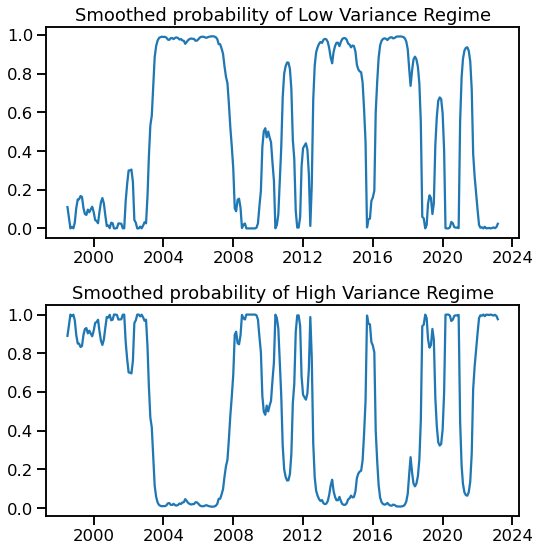

In [26]:
getmarkovsummary(SPY_ret, "1998-07-01")

In [27]:
def getmarkovregime(df, start,end):
    df1 = df.copy()
    df1 = df1.loc[start:end]
    model = MarkovRegression(df1, k_regimes=2, switching_variance=True).fit()
    regime = model.smoothed_marginal_probabilities.values.argmax(axis=1)
         #regime classification not forward predictions
         # 0 is good state, 1 is bad state 

    frame = pd.DataFrame(regime, index = df1.index, columns = ["State"])    
    return frame         

In [28]:
getmarkovregime(SPY_ret, "1998-07-01","2018-05-01").value_counts()

State
0        126
1        113
dtype: int64

In [29]:
BMv

,Book_to_Market-B-v,Book_to_Market-S-v
1963-07-01,-0.018143,-0.001242
1963-08-01,0.023484,0.012425
1963-09-01,-0.007856,0.010389
1963-10-01,-0.017112,0.015143
1963-11-01,0.009321,0.025673
...,...,...
2022-11-01,-0.002919,0.030592
2022-12-01,0.022289,0.004134
2023-01-01,-0.023248,-0.057714
2023-02-01,-0.023279,0.007586


In [30]:
np.sign(BMv).replace([1,-1], [0,1])

,Book_to_Market-B-v,Book_to_Market-S-v
1963-07-01,1.0,1.0
1963-08-01,0.0,0.0
1963-09-01,1.0,0.0
1963-10-01,1.0,0.0
1963-11-01,0.0,0.0
...,...,...
2022-11-01,1.0,0.0
2022-12-01,0.0,0.0
2023-01-01,1.0,1.0
2023-02-01,1.0,0.0


In [31]:
def markov_getclasstable(regress_inst,trade_inst,start, MarketCapSize):
    df1 = regress_inst.copy() #regimes are classified based on this underlying instrument
    df1 = df1.loc[start:]
    df2 = trade_inst.copy() #this is the trading instrument used to 
    df2 = df2.loc[start:]

    model = MarkovRegression(df1, k_regimes=2, switching_variance=True).fit()
    regime = model.smoothed_marginal_probabilities.values.argmax(axis=1)

    frame = pd.DataFrame(regime, index = df1.index, columns = ["State"])        
    regimeclasses = frame.iloc[:-1]
    
    if MarketCapSize == "big":
        actual_ret = df2.iloc[:,0].shift(-1).dropna()
    elif MarketCapSize == "small":
        actual_ret = df2.iloc[:,1].shift(-1).dropna()
        
    actual_ret = np.sign(actual_ret).replace([1,-1], [0,1])
    
    print(classification_report(actual_ret,regimeclasses))

In [32]:
markov_getclasstable(SPY_ret,CPv,"1998-07-01", "small")

              precision    recall  f1-score   support

         0.0       0.54      0.50      0.52       159
         1.0       0.47      0.50      0.48       137

    accuracy                           0.50       296
   macro avg       0.50      0.50      0.50       296
weighted avg       0.51      0.50      0.50       296



In [33]:
# BMv, BMe 
# CPv, CPe 
# DPv, DPe
# EPv, EPe 
# OPv, OPe 
# INv, INe
# PRv, PRe
# SMv, SMe
# LMv, LMe

In [34]:
# print("portfolios are:", portfolios)

In [35]:
portfolios = [BMv, BMe, CPv, CPe, DPv, DPe, EPv, EPe, OPv, OPe, INv, INe, PRv, PRe, SMv, SMe, LMv, LMe]

def multigetclasstables(trade_inst,ports,start):
    
    class_tables = []
    for i in ports:
        concat = []
        bigcap = markov_getclasstable(trade_inst,i, start,"big")
        smallcap = markov_getclasstable(trade_inst,i, start,"small")
        concat.append(bigcap)
        concat.append(smallcap)
        print("this class table is for:", i.columns)
        class_tables.append(concat)
        
    return class_tables    

In [36]:
multigetclasstables(SPY_ret,portfolios,"1998-07-01")

              precision    recall  f1-score   support

         0.0       0.46      0.51      0.48       133
         1.0       0.56      0.51      0.53       163

    accuracy                           0.51       296
   macro avg       0.51      0.51      0.51       296
weighted avg       0.52      0.51      0.51       296

              precision    recall  f1-score   support

         0.0       0.45      0.47      0.46       144
         1.0       0.48      0.47      0.47       152

    accuracy                           0.47       296
   macro avg       0.47      0.47      0.47       296
weighted avg       0.47      0.47      0.47       296

this class table is for: Index(['Book_to_Market-B-v', 'Book_to_Market-S-v'], dtype='object')
              precision    recall  f1-score   support

         0.0       0.49      0.50      0.50       146
         1.0       0.51      0.50      0.50       150

    accuracy                           0.50       296
   macro avg       0.50      0.50  

              precision    recall  f1-score   support

         0.0       0.53      0.44      0.48       180
         1.0       0.32      0.41      0.36       116

    accuracy                           0.43       296
   macro avg       0.43      0.42      0.42       296
weighted avg       0.45      0.43      0.43       296

this class table is for: Index(['Investment-B-e', 'Investment-S-e'], dtype='object')
              precision    recall  f1-score   support

         0.0       0.52      0.50      0.51       155
         1.0       0.47      0.50      0.48       141

    accuracy                           0.50       296
   macro avg       0.50      0.50      0.50       296
weighted avg       0.50      0.50      0.50       296

              precision    recall  f1-score   support

         0.0       0.54      0.52      0.53       154
         1.0       0.50      0.52      0.51       142

    accuracy                           0.52       296
   macro avg       0.52      0.52      0.52

[[None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None]]

In [37]:
BMv.columns

Index(['Book_to_Market-B-v', 'Book_to_Market-S-v'], dtype='object')

In [38]:
# BMv, BMe 
# CPv, CPe 
# DPv, DPe
# EPv, EPe 
# OPv, OPe 
# INv, INe
# PRv, PRe
# SMv, SMe
# LMv, LMe

In [39]:
def get_famma_buynhold(df,start,end,rf_rate):
    df1 = df.copy()
    df1 = df1.loc[start:end]
    df2 = rf_rate.copy()
    df2 = df2.loc[start:end]
    combined = []
    for count, i in enumerate(df1.columns):
        cum_ret = (1+ df1.iloc[:,count]).cumprod()
        sharpe = ((df1.iloc[:,count]-df2).mean()/((df1.iloc[:,count]-df2).std()))*np.sqrt(12)
        cagr = (cum_ret[-1]**(12/len(df1.iloc[:,count])))-1
        vol =  (df1.iloc[:,count].std())*np.sqrt(12)
        key = [sharpe,cagr,vol]
        stats = pd.DataFrame(key, index = ["BnH Sharpe","BnH CAGR","BnH Volatility"], columns = [df1.iloc[:,count].name])
        combined.append(stats)
        combined_df = pd.concat(combined, axis = 1).T
        
        
    return combined_df


In [40]:
get_famma_buynhold(CPv,"1998-07-01","2018-05-01",rfr)

,BnH Sharpe,BnH CAGR,BnH Volatility
Cashflow_to_Price-B-v,-0.091017,0.002553,0.107579
Cashflow_to_Price-S-v,0.047031,0.017922,0.099304


In [41]:
def BnH_results(ports,start,end):
    
    results_list = []
    for i in ports:
        results_famma_bnh = get_famma_buynhold(i,start,end,rfr) #change rates here
        results_list.append(results_famma_bnh)
        BnH_results_df = pd.concat(results_list)
    print("the max,min,mean,median BnH sharpe are:", BnH_results_df["BnH Sharpe"].max(),\
                                                 BnH_results_df["BnH Sharpe"].min(),\
                                                 BnH_results_df["BnH Sharpe"].mean(),\
                                                 BnH_results_df["BnH Sharpe"].median()
         )
    print("the max,min,mean,median BnH volatility are:", BnH_results_df["BnH Volatility"].max(),\
                                                      BnH_results_df["BnH Volatility"].min(),\
                                                     BnH_results_df["BnH Volatility"].mean(),\
                                                    BnH_results_df["BnH Volatility"].median()

         )
    print("the max,min,mean,median,BnH CAGR of Returns are:", BnH_results_df["BnH CAGR"].max(),\
                                                           BnH_results_df["BnH CAGR"].min(),\
                                                          BnH_results_df["BnH CAGR"].mean(),\
                                                          BnH_results_df["BnH CAGR"].median()
         )

    return BnH_results_df.sort_values(by = "BnH Sharpe", ascending = False)


# <font color = "blue"> 3) Train set results

In [42]:
BnH_results_train = BnH_results(portfolios,"1998-07-01","2018-05-01")
BnH_results_validation = BnH_results(portfolios,"2013-05-01","2018-04-01")
BnH_results_test = BnH_results(portfolios,"2018-05-01","2023-03-01")

the max,min,mean,median BnH sharpe are: 0.8471159383981997 -0.4403934992932141 0.05114792344642427 0.04590492374915827
the max,min,mean,median BnH volatility are: 0.2000684229112829 0.06867831772255006 0.11876077255127436 0.10645843151196474
the max,min,mean,median,BnH CAGR of Returns are: 0.0865151017581971 -0.021039154790163717 0.017751499988574233 0.01767244194456241
the max,min,mean,median BnH sharpe are: 0.5295094924813288 -0.8426024001596357 -0.14275308676238732 -0.1564355826478877
the max,min,mean,median BnH volatility are: 0.12124169389687299 0.037639117769159756 0.07274116286910033 0.07173259100705409
the max,min,mean,median,BnH CAGR of Returns are: 0.05125964858863585 -0.07285873495130002 -0.0074395147578655224 -0.009341713473927316
the max,min,mean,median BnH sharpe are: 1.0323949580435146 -0.5492556932175923 0.06502562380347593 0.07215909527723688
the max,min,mean,median BnH volatility are: 0.19546258022662197 0.0622194128553202 0.13491425938768836 0.1353071139142109
the ma

In [43]:
BnH_results_validation.describe()

,BnH Sharpe,BnH CAGR,BnH Volatility
count,36.000000,36.000000,36.000000
mean,-0.142753,-0.007440,0.072741
std,0.364355,0.026756,0.019076
min,-0.842602,-0.072859,0.037639
25%,-0.385627,-0.027500,0.058116
50%,-0.156436,-0.009342,0.071733
75%,0.092281,0.007178,0.081830
max,0.529509,0.051260,0.121242


In [44]:
BnH_results_test.describe()

,BnH Sharpe,BnH CAGR,BnH Volatility
count,36.000000,36.000000,36.000000
mean,0.065026,0.009245,0.134914
std,0.357259,0.046912,0.032633
min,-0.549256,-0.073302,0.062219
25%,-0.244112,-0.025109,0.111925
50%,0.072159,0.015138,0.135307
75%,0.271533,0.041950,0.162551
max,1.032395,0.106889,0.195463


In [45]:
BnH_results_train

,BnH Sharpe,BnH CAGR,BnH Volatility
Investment-S-e,0.847116,0.086515,0.081107
Investment-S-v,0.334330,0.040825,0.074506
Prior_Month_Return-S-e,0.316578,0.055722,0.146844
Book_to_Market-S-e,0.276640,0.047828,0.139752
12_1_Momentum-S-e,0.195074,0.035448,0.185770
Operating_Profitability-B-v,0.188347,0.032733,0.103885
Cashflow_to_Price-S-e,0.183213,0.029278,0.073985
Investment-B-e,0.170473,0.030523,0.099737
12_1_Momentum-S-v,0.152592,0.027616,0.192149
60_13_Momentum-S-e,0.149436,0.028725,0.105066


In [46]:
BnH_results_test.head(10).describe()

,BnH Sharpe,BnH CAGR,BnH Volatility
count,10.000000,10.000000,10.000000
mean,0.507221,0.067095,0.127788
std,0.245627,0.021128,0.031597
min,0.261504,0.041382,0.089197
25%,0.332318,0.050205,0.096699
50%,0.425837,0.065512,0.129697
75%,0.656543,0.082123,0.152071
max,1.032395,0.106889,0.174378


In [47]:
BnH_results_test.tail(10).describe()

,BnH Sharpe,BnH CAGR,BnH Volatility
count,10.000000,10.000000,10.000000
mean,-0.328759,-0.043104,0.139984
std,0.087974,0.020217,0.031293
min,-0.549256,-0.073302,0.097343
25%,-0.345427,-0.058112,0.117016
50%,-0.305087,-0.036999,0.133175
75%,-0.277894,-0.028554,0.157077
max,-0.234721,-0.019626,0.195463


In [48]:
BnH_results_test.describe()

,BnH Sharpe,BnH CAGR,BnH Volatility
count,36.000000,36.000000,36.000000
mean,0.065026,0.009245,0.134914
std,0.357259,0.046912,0.032633
min,-0.549256,-0.073302,0.062219
25%,-0.244112,-0.025109,0.111925
50%,0.072159,0.015138,0.135307
75%,0.271533,0.041950,0.162551
max,1.032395,0.106889,0.195463


In [49]:
# fig, axes = plt.subplots(2,2, figsize = (8,8))
# axes = axes.flatten()
# axes[0].hist(BnH_results_df["BnH Sharpe"], label = "Sharpe",
#             color = "red")
# axes[1].hist(BnH_results_df["BnH CAGR"], label = "CAGR",
#             color = "blue")
# axes[2].hist(BnH_results_df["BnH Volatility"], label = "Volatility",
#             color = "green")
# for i in range(0,3):
#     axes[i].legend()
# plt.show()

In [50]:
BMvH,BMvL = BMv.iloc[:,0], BMv.iloc[:,1]
BMeH,BMeL = BMe.iloc[:,0], BMe.iloc[:,1]  
CPvH,CPvL = CPv.iloc[:,0], CPv.iloc[:,1] 
CPeH,CPeL = CPe.iloc[:,0], CPe.iloc[:,1]
DPvH,DPvL = DPv.iloc[:,0], DPv.iloc[:,1]
DPeH,DPeL = DPe.iloc[:,0], DPe.iloc[:,1]
EPvH,EPvL = EPv.iloc[:,0], EPv.iloc[:,1]
EPeH,EPeL = EPe.iloc[:,0], EPe.iloc[:,1]
OPvH,OPvL = OPv.iloc[:,0], OPv.iloc[:,1]
OPeH,OPeL = OPe.iloc[:,0], OPe.iloc[:,1]
INvH,INvL = INv.iloc[:,0], INv.iloc[:,1]
INeH,INeL = INe.iloc[:,0], INe.iloc[:,1]
PRvH,PRvL = PRv.iloc[:,0], PRv.iloc[:,1]
PReH,PReL = PRe.iloc[:,0], PRe.iloc[:,1]
SMvH,SMvL = SMv.iloc[:,0], SMv.iloc[:,1]
SMeH,SMeL = SMe.iloc[:,0], SMe.iloc[:,1]
LMvH,LMvL = LMv.iloc[:,0], LMv.iloc[:,1]
LMeH,LMeL = LMe.iloc[:,0], LMe.iloc[:,1]

In [51]:
new_ports = [BMvH,BMvL,BMeH,BMeL,CPvH,CPvL,CPeH,CPeL,DPvH,DPvL,\
             DPeH,DPeL,EPvH,EPvL,EPeH,EPeL,OPvH,OPvL,OPeH,OPeL,\
             INvH,INvL,INeH,INeL,PRvH,PRvL,PReH,PReL,SMvH,SMvL,\
             SMeH,SMeL,LMvH,LMvL,LMeH,LMeL]

In [52]:
LMvH

1963-07-01    0.0036
1963-08-01    0.0223
1963-09-01   -0.0023
1963-10-01    0.0006
1963-11-01   -0.0077
               ...  
2022-11-01    0.0073
2022-12-01    0.0368
2023-01-01   -0.0072
2023-02-01   -0.0162
2023-03-01   -0.0765
Name: 60_13_Momentum-B-v, Length: 717, dtype: float64

In [53]:
BMvL

1963-07-01   -0.001242
1963-08-01    0.012425
1963-09-01    0.010389
1963-10-01    0.015143
1963-11-01    0.025673
                ...   
2022-11-01    0.030592
2022-12-01    0.004134
2023-01-01   -0.057714
2023-02-01    0.007586
2023-03-01   -0.060128
Name: Book_to_Market-S-v, Length: 717, dtype: float64

In [54]:
EPvH

1963-07-01    0.0137
1963-08-01    0.0080
1963-09-01   -0.0115
1963-10-01    0.0311
1963-11-01   -0.0518
               ...  
2022-11-01    0.0181
2022-12-01    0.0233
2023-01-01   -0.0184
2023-02-01   -0.0216
2023-03-01   -0.1226
Name: Earning_to_Price-B-v, Length: 717, dtype: float64

In [55]:
# def get_PnL(regress_inst,trade_inst, start):
    
#     trade_inst1 = trade_inst.copy()
#     results_df = pd.DataFrame()
#     results_df["states"] = getmarkovregime(regress_inst, start)
#     results_df["positions"] = results_df["states"].shift(1)
#     results_df["actual_ret"] = trade_inst1.loc[start:] 
#     results_df["strat_ret"] = results_df["actual_ret"]*results_df["positions"]
#     results_df["cum_ret"] = (1+results_df["strat_ret"].dropna()).cumprod()

#     return results_df

In [56]:
def get_PnL(regress_inst,trade_inst, start, end): #including commissions
    fee = 10/100/100  #10bps
    trade_inst1 = trade_inst.copy()
    results_df = pd.DataFrame()
    results_df["states"] = getmarkovregime(regress_inst, start,end)
    results_df["positions"] = results_df["states"].shift(1)
    results_df["execution"] = results_df["positions"].diff()
    results_df["actual_ret"] = trade_inst1.loc[start:end] 
    results_df["strat_ret"] = results_df["actual_ret"]*results_df["positions"]
    results_df["net_strat_ret"] = 0.0
    
    for i in range(len(results_df.index)):
        if results_df["execution"][i] == 1:
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i] - fee
        elif results_df["execution"][i] == -1:
            results_df["net_strat_ret"][i-1] = results_df["strat_ret"][i-1] - fee 
        else:
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i]        
    if results_df["positions"][1] == 1:
        results_df["execution"][1] = 1 
        results_df["net_strat_ret"][1] = results_df["net_strat_ret"][1]-fee
            
    results_df["cum_ret"] = (1+results_df["net_strat_ret"].dropna()).cumprod()

    return results_df

In [57]:
def get_PnL_LS(regress_inst,trade_inst, start, end): #including commissions
    fee = 10/100/100  #10bps
    trade_inst1 = trade_inst.copy()
    results_df = pd.DataFrame()
    results_df["states"] = getmarkovregime(regress_inst, start,end)
    results_df["positions"] = results_df["states"].shift(1).replace([0,1],[1,-1])
    results_df["execution"] = results_df["positions"].diff()
    results_df["actual_ret"] = trade_inst1.loc[start:end] 
    results_df["strat_ret"] = results_df["actual_ret"]*results_df["positions"]
    results_df["net_strat_ret"] = 0.0
    
    for i in range(len(results_df.index)):
        if results_df["execution"][i] == -2: #long change to short position
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i] - 2*fee
            
        elif results_df["execution"][i] == 2: #short change to long position
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i] - 2*fee
            
        else:
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i]        
    if results_df["positions"][1] == 1:
        results_df["net_strat_ret"][1] = results_df["net_strat_ret"][1]-fee
        
    elif results_df["positions"][1] == -1:
        results_df["net_strat_ret"][1] = results_df["net_strat_ret"][1]-fee 
            
    results_df["cum_ret"] = (1+results_df["net_strat_ret"].dropna()).cumprod()

    return results_df

In [58]:
get_PnL_LS(SPY_ret,BMvL,"1998-07-01","2023-03-01")

,states,positions,execution,actual_ret,strat_ret,net_strat_ret,cum_ret
Date,,,,,,,
1998-07-01,1,NaN,NaN,0.003666,NaN,NaN,NaN
1998-08-01,1,-1.0,NaN,0.055635,-0.055635,-0.056635,0.943365
1998-09-01,1,-1.0,0.0,-0.054581,0.054581,0.054581,0.994855
1998-10-01,1,-1.0,0.0,-0.010833,0.010833,0.010833,1.005632
1998-11-01,1,-1.0,0.0,-0.035162,0.035162,0.035162,1.040992
...,...,...,...,...,...,...,...
2022-11-01,1,-1.0,0.0,0.030592,-0.030592,-0.030592,0.490148
2022-12-01,1,-1.0,0.0,0.004134,-0.004134,-0.004134,0.488122
2023-01-01,1,-1.0,0.0,-0.057714,0.057714,0.057714,0.516294


In [59]:
get_PnL_LS(DPeL,INeL,"1998-07-01","2018-05-01")

,states,positions,execution,actual_ret,strat_ret,net_strat_ret,cum_ret
1998-07-01,1,NaN,NaN,0.025078,NaN,NaN,NaN
1998-08-01,1,-1.0,NaN,0.026331,-0.026331,-0.027331,0.972669
1998-09-01,1,-1.0,0.0,-0.012778,0.012778,0.012778,0.985098
1998-10-01,1,-1.0,0.0,-0.029681,0.029681,0.029681,1.014336
1998-11-01,1,-1.0,0.0,0.028972,-0.028972,-0.028972,0.984949
...,...,...,...,...,...,...,...
2018-01-01,0,1.0,0.0,0.015118,0.015118,0.015118,0.254284
2018-02-01,0,1.0,0.0,-0.006457,-0.006457,-0.006457,0.252642
2018-03-01,0,1.0,0.0,-0.010370,-0.010370,-0.010370,0.250022
2018-04-01,0,1.0,0.0,0.007766,0.007766,0.007766,0.251964


In [60]:
get_PnL(SPY_ret,BMvL,"1998-07-01","2018-05-01")

,states,positions,execution,actual_ret,strat_ret,net_strat_ret,cum_ret
Date,,,,,,,
1998-07-01,1,NaN,NaN,0.003666,NaN,NaN,NaN
1998-08-01,1,1.0,1.0,0.055635,0.055635,0.054635,1.054635
1998-09-01,1,1.0,0.0,-0.054581,-0.054581,-0.054581,0.997072
1998-10-01,1,1.0,0.0,-0.010833,-0.010833,-0.010833,0.986271
1998-11-01,1,1.0,0.0,-0.035162,-0.035162,-0.035162,0.951591
...,...,...,...,...,...,...,...
2018-01-01,0,0.0,0.0,-0.013977,-0.000000,-0.000000,1.608401
2018-02-01,0,0.0,0.0,-0.006863,-0.000000,-0.000000,1.608401
2018-03-01,0,0.0,0.0,0.005031,0.000000,0.000000,1.608401


In [61]:
def key_stats(df):
    df1 = df.copy()
    df2 = rfr.copy()
    df2 = df2[df2.index.isin(df1.index)]
    CAGR = ((df1["cum_ret"][-1])**(12/(len(df1))))-1
    sharpe = ((df1["strat_ret"] - df2).dropna().mean()/ (df1["strat_ret"] - df2).dropna().std())*np.sqrt(12)
    volatility = df1["strat_ret"].std()*np.sqrt(12)
    key = [sharpe,CAGR,volatility]
    stats = pd.DataFrame(key, index = ["Strat Sharpe","Strat CAGR","Strat Volatility"], columns = ["strat"])
    return stats

In [62]:
key_stats(get_PnL(SPY_ret,LMeH,"1998-07-01","2018-05-01"))

,strat
Strat Sharpe,0.149224
Strat CAGR,0.026714
Strat Volatility,0.083359


In [63]:
def get_strat_results(dfs, regress_inst, start,end):
    bigsmall_list = []
    for count,i in enumerate(dfs):
        bigsmall = []
        big = key_stats(get_PnL(regress_inst, i.iloc[:,0],start,end))
        small = key_stats(get_PnL(regress_inst, i.iloc[:,1],start,end))
        bigsmall.append(big)
        bigsmall.append(small)
        bigsmall_df = pd.concat(bigsmall, axis = 1)
        bigsmall_df.columns = dfs[count].columns
        bigsmall_list.append(bigsmall_df)
        bigsmall_list_df = pd.concat(bigsmall_list, axis = 1).T
        
    return bigsmall_list_df.sort_values(by = "Strat Sharpe", ascending = False)

In [64]:
def get_strat_results_LS(dfs, regress_inst, start,end):
    bigsmall_list = []
    for count,i in enumerate(dfs):
        bigsmall = []
        big = key_stats(get_PnL_LS(regress_inst, i.iloc[:,0],start,end))
        small = key_stats(get_PnL_LS(regress_inst, i.iloc[:,1],start,end))
        bigsmall.append(big)
        bigsmall.append(small)
        bigsmall_df = pd.concat(bigsmall, axis = 1)
        bigsmall_df.columns = dfs[count].columns
        bigsmall_list.append(bigsmall_df)
        bigsmall_list_df = pd.concat(bigsmall_list, axis = 1).T
        
    return bigsmall_list_df.sort_values(by = "Strat Sharpe", ascending = False)

In [65]:
get_strat_results_LS(portfolios, VIX,"1998-07-01","2018-05-01")

,Strat Sharpe,Strat CAGR,Strat Volatility
Operating_Profitability-S-e,0.104396,0.022949,0.120090
Book_to_Market-B-v,0.084481,0.020258,0.123036
12_1_Momentum-S-e,-0.078063,-0.013458,0.186753
Cashflow_to_Price-B-v,-0.100109,0.000594,0.107711
Book_to_Market-S-e,-0.104565,-0.007293,0.140915
Operating_Profitability-S-v,-0.111546,-0.006133,0.132876
Cashflow_to_Price-B-e,-0.148160,-0.003070,0.101806
Book_to_Market-B-e,-0.151644,-0.008450,0.120759
12_1_Momentum-S-v,-0.160142,-0.030934,0.192748
12_1_Momentum-B-e,-0.186427,-0.039128,0.200597


In [66]:
get_strat_results(portfolios, SPY_ret,"1998-07-01","2018-05-01")

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.790354,0.070702,0.068240
Investment-S-v,0.449384,0.044798,0.064013
Prior_Month_Return-S-e,0.319736,0.053957,0.139047
Operating_Profitability-B-v,0.300352,0.041709,0.092528
Investment-B-e,0.245562,0.036556,0.093482
60_13_Momentum-S-e,0.187071,0.030407,0.087265
60_13_Momentum-B-v,0.162880,0.028871,0.097031
Operating_Profitability-B-e,0.162534,0.030023,0.116108
60_13_Momentum-B-e,0.149224,0.026714,0.083359
Book_to_Market-S-e,0.134788,0.026628,0.127900


In [67]:
get_strat_results(portfolios, SPY_ret, "1998-07-01","2018-05-01").head()

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.790354,0.070702,0.068240
Investment-S-v,0.449384,0.044798,0.064013
Prior_Month_Return-S-e,0.319736,0.053957,0.139047
Operating_Profitability-B-v,0.300352,0.041709,0.092528
Investment-B-e,0.245562,0.036556,0.093482


In [68]:
get_strat_results(portfolios, VIX,"1998-07-01","2018-05-01").head(10)

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.905854,0.082183,0.071421
Investment-S-v,0.489999,0.048395,0.065812
Prior_Month_Return-S-e,0.302007,0.051558,0.139684
60_13_Momentum-S-e,0.287369,0.040212,0.090793
Operating_Profitability-B-v,0.212247,0.033656,0.095216
Investment-B-e,0.193916,0.031709,0.093919
60_13_Momentum-S-v,0.190894,0.029616,0.077157
60_13_Momentum-B-v,0.144950,0.027294,0.099632
60_13_Momentum-B-e,0.111554,0.023644,0.085596
Operating_Profitability-B-e,0.070988,0.019199,0.117275


In [69]:
get_strat_results(portfolios, DFF,"1998-07-01","2018-05-01").head(10)

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.541574,0.053059,0.068491
12_1_Momentum-S-v,0.319033,0.055630,0.153221
12_1_Momentum-S-e,0.294065,0.050543,0.153819
12_1_Momentum-B-e,0.224156,0.041887,0.168692
Prior_Month_Return-S-e,0.202773,0.036955,0.134009
12_1_Momentum-B-v,0.200258,0.037428,0.162561
Operating_Profitability-B-v,0.185969,0.031031,0.092487
Book_to_Market-S-e,0.177614,0.032589,0.130263
Investment-S-v,0.173487,0.027085,0.065268
Prior_Month_Return-B-v,0.102239,0.022708,0.133538


In [70]:
get_strat_results(portfolios, oilprc,"1998-07-01","2018-05-01").head(10)

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.187635,2.670917e-02,0.052962
12_1_Momentum-B-v,0.121465,2.463657e-02,0.132699
12_1_Momentum-S-e,0.090605,2.101156e-02,0.115399
Operating_Profitability-B-v,0.067375,2.014518e-02,0.059499
Prior_Month_Return-S-e,0.042458,1.809685e-02,0.081169
12_1_Momentum-B-e,0.029474,1.298550e-02,0.125088
Operating_Profitability-S-v,-0.026117,1.536519e-02,0.048396
Operating_Profitability-S-e,-0.056955,1.323773e-02,0.053983
12_1_Momentum-S-v,-0.067900,-4.894170e-07,0.125977
Book_to_Market-S-e,-0.115043,8.063416e-03,0.065427


In [71]:
get_strat_results(portfolios, BMvH,"1998-07-01","2018-05-01").head(10)

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.485117,0.047290,0.064592
60_13_Momentum-B-v,0.309959,0.040586,0.083788
Investment-S-v,0.282939,0.033017,0.060105
60_13_Momentum-B-e,0.212836,0.030792,0.072942
Prior_Month_Return-S-e,0.212329,0.037812,0.130135
Operating_Profitability-B-v,0.162452,0.028056,0.084401
60_13_Momentum-S-v,0.146985,0.025233,0.064719
Investment-B-e,0.143302,0.026678,0.089909
Book_to_Market-S-v,0.129639,0.026042,0.109998
60_13_Momentum-S-e,0.129604,0.024939,0.078329


In [72]:
get_strat_results(portfolios, CPeL,"1998-07-01","2018-05-01").head(10)

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.489442,0.048369,0.066093
60_13_Momentum-B-v,0.237541,0.034454,0.084754
Operating_Profitability-B-v,0.220902,0.033397,0.087415
Investment-S-v,0.208924,0.028144,0.058258
Operating_Profitability-B-e,0.183025,0.032302,0.114281
Investment-B-e,0.151246,0.027291,0.089687
Investment-B-v,0.130501,0.025233,0.085843
60_13_Momentum-S-e,0.118542,0.023983,0.077981
Prior_Month_Return-S-e,0.115858,0.024858,0.132031
Book_to_Market-S-v,0.106806,0.023369,0.111504


In [73]:
get_strat_results(portfolios, DPvH,"1998-07-01","2018-05-01").head(10)

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.512423,0.044910,0.056066
Investment-S-v,0.265137,0.030993,0.056035
12_1_Momentum-S-v,0.263502,0.044403,0.134344
Operating_Profitability-B-v,0.240472,0.034631,0.083588
12_1_Momentum-S-e,0.212546,0.036218,0.134065
Prior_Month_Return-S-e,0.205738,0.037074,0.132341
60_13_Momentum-B-v,0.176422,0.029384,0.086971
12_1_Momentum-B-e,0.170287,0.032231,0.150878
12_1_Momentum-B-v,0.156344,0.029878,0.145674
Investment-B-e,0.125890,0.025003,0.088928


In [74]:
get_strat_results(portfolios, DPeL,"1998-07-01","2018-05-01").head(10)

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.833898,0.075063,0.069434
Investment-S-v,0.455226,0.045693,0.064750
Prior_Month_Return-S-e,0.318220,0.053882,0.138686
60_13_Momentum-S-e,0.226548,0.034392,0.088944
Operating_Profitability-B-v,0.186033,0.031146,0.094009
60_13_Momentum-B-v,0.178405,0.030602,0.096805
Investment-B-e,0.145403,0.027146,0.092915
60_13_Momentum-S-v,0.112906,0.023583,0.076053
Cashflow_to_Price-S-e,0.112159,0.023058,0.064752
60_13_Momentum-B-e,0.111032,0.023684,0.083495


In [207]:
len(new_ports)

36

In [210]:
results_table_list = []
for i in new_ports:

    results_table = get_strat_results(portfolios, i,"1998-07-01","2018-05-01").head(10)
    results_table_list.append(results_table)
    results_table_df = pd.concat(results_table_list, axis = 0, keys = [K.name for K in new_ports])
    
results_table_df
    

Strat Sharpe  Strat CAGR  \
Book_to_Market-B-v Investment-S-e              0.485117    0.047493   
                   60_13_Momentum-B-v          0.309959    0.040760   
                   Investment-S-v              0.282939    0.033158   
                   60_13_Momentum-B-e          0.212836    0.030923   
                   Prior_Month_Return-S-e      0.212329    0.037974   
...                                                 ...         ...   
60_13_Momentum-S-e 60_13_Momentum-S-v          0.266403    0.034168   
                   60_13_Momentum-B-e          0.185858    0.028971   
                   Prior_Month_Return-B-e      0.159349    0.030599   
                   Prior_Month_Return-B-v      0.154229    0.029581   
                   Investment-B-e              0.132797    0.025981   

                                           Strat Volatility  
Book_to_Market-B-v Investment-S-e                  0.064592  
                   60_13_Momentum-B-v              0.083788  
                   Investment-S-v                  0.060105  
                   60_13_Momentum-B-e              0.072942  
                   Prior_Month_Return-S-e          0.130135  
...                                                     ...  
60_13_Momentum-S-e 60_13_Momentum-S-v              0.068418  
                   60_13_Momentum-B-e              0.072669  
                   Prior_Month_Return-B-e          0.130235  
                   Prior_Month_Return-B-v          0.123859  
                   Investment-B-e                  0.091032  

[360 rows x 3 columns]

In [217]:
results_table_df.index

MultiIndex([('Book_to_Market-B-v',              'Investment-S-e'),
            ('Book_to_Market-B-v',          '60_13_Momentum-B-v'),
            ('Book_to_Market-B-v',              'Investment-S-v'),
            ('Book_to_Market-B-v',          '60_13_Momentum-B-e'),
            ('Book_to_Market-B-v',      'Prior_Month_Return-S-e'),
            ('Book_to_Market-B-v', 'Operating_Profitability-B-v'),
            ('Book_to_Market-B-v',          '60_13_Momentum-S-v'),
            ('Book_to_Market-B-v',              'Investment-B-e'),
            ('Book_to_Market-B-v',          'Book_to_Market-S-v'),
            ('Book_to_Market-B-v',          '60_13_Momentum-S-e'),
            ...
            ('60_13_Momentum-S-e',              'Investment-S-e'),
            ('60_13_Momentum-S-e',              'Investment-S-v'),
            ('60_13_Momentum-S-e',          '60_13_Momentum-S-e'),
            ('60_13_Momentum-S-e',      'Prior_Month_Return-S-e'),
            ('60_13_Momentum-S-e',          '6

In [218]:
results_table_df.index.get_level_values(0)

Index(['Book_to_Market-B-v', 'Book_to_Market-B-v', 'Book_to_Market-B-v',
       'Book_to_Market-B-v', 'Book_to_Market-B-v', 'Book_to_Market-B-v',
       'Book_to_Market-B-v', 'Book_to_Market-B-v', 'Book_to_Market-B-v',
       'Book_to_Market-B-v',
       ...
       '60_13_Momentum-S-e', '60_13_Momentum-S-e', '60_13_Momentum-S-e',
       '60_13_Momentum-S-e', '60_13_Momentum-S-e', '60_13_Momentum-S-e',
       '60_13_Momentum-S-e', '60_13_Momentum-S-e', '60_13_Momentum-S-e',
       '60_13_Momentum-S-e'],
      dtype='object', length=360)

In [234]:
series1 = pd.DataFrame([1,2,3], index = ["A","B","C"], columns = ["X1"])
series1["yo"] = 0.0
series1["yo"] = series1["yo"].apply(lambda x: np.random.rand())
series2 = pd.DataFrame([4,5,6,7,8], index = ["A","B","C","D","E"], columns = ["X1"])
series2["siuu"] = 0.0
series2["siuu"] = series2["siuu"].apply(lambda x: np.random.rand())

In [238]:
series1

,X1,yo
A,1,0.638327
B,2,0.628204
C,3,0.785093


In [239]:
series2

,X1,siuu
A,4,0.388587
B,5,0.898731
C,6,0.408265
D,7,0.617196
E,8,0.529204


In [243]:
pd.merge(series1,series2, how = "left", on = "X1")

,X1,yo,siuu
0,1,0.638327,NaN
1,2,0.628204,NaN
2,3,0.785093,NaN


In [219]:
try2 = []
for i in new_ports:

    try1 = get_strat_results(portfolios, i,"1998-07-01","2018-05-01").median()
    try2.append(try1)
    
try2

[Strat Sharpe        0.005494
 Strat CAGR          0.013048
 Strat Volatility    0.089926
 dtype: float64,
 Strat Sharpe        0.038282
 Strat CAGR          0.017503
 Strat Volatility    0.089143
 dtype: float64,
 Strat Sharpe       -0.162535
 Strat CAGR         -0.000297
 Strat Volatility    0.082368
 dtype: float64,
 Strat Sharpe        0.032413
 Strat CAGR          0.016060
 Strat Volatility    0.077027
 dtype: float64,
 Strat Sharpe       -0.129445
 Strat CAGR          0.003546
 Strat Volatility    0.075491
 dtype: float64,
 Strat Sharpe        0.046075
 Strat CAGR          0.018160
 Strat Volatility    0.088778
 dtype: float64,
 Strat Sharpe       -0.014314
 Strat CAGR          0.011051
 Strat Volatility    0.088117
 dtype: float64,
 Strat Sharpe        0.004248
 Strat CAGR          0.013238
 Strat Volatility    0.089128
 dtype: float64,
 Strat Sharpe       -0.003142
 Strat CAGR          0.010948
 Strat Volatility    0.087950
 dtype: float64,
 Strat Sharpe       -0.052195
 Strat 

In [75]:
def diff_in(strategy,actual, method):
    diffs = pd.DataFrame()
    diffs_list = []
    strategy1 = strategy.copy()
    actual1 = actual.copy()
    filtered_df = pd.DataFrame()
    if method == "sharpe":   
        strategy_plus = strategy1[strategy1["Strat Sharpe"] > 0]
        actual2 = actual1[actual1.index.isin(strategy_plus.index)]
                         
        names = ["Sharpe","CAGR","Volatility"]
        for count, i in enumerate(names):
            diffs = strategy_plus.iloc[:,count] - actual2.iloc[:,count]
            diffs_list.append(diffs)
            diffs_df = pd.concat(diffs_list, axis = 1)
        diffs_df.columns = names

        filtered_df = diffs_df[diffs_df["Sharpe"] > 0]
        
    elif method == "cagr":   
        strategy_plus = strategy1[strategy1["Strat CAGR"] > 0]
        actual2 = actual1[actual1.index.isin(strategy_plus.index)]
                         
        names = ["Sharpe","CAGR","Volatility"]
        for count, i in enumerate(names):
            diffs = strategy_plus.iloc[:,count] - actual2.iloc[:,count]
            diffs_list.append(diffs)
            diffs_df = pd.concat(diffs_list, axis = 1)
        diffs_df.columns = names

        filtered_df = diffs_df[diffs_df["CAGR"] > 0]
                         
#     print("the portfolios that beat the buy-and-hold SHARPE are:",beat_sharpes)
#     print("the portfolios that beat the buy-and-hold CAGR are:",beat_cagr)
#     print("the portfolios that beat the buy-and-hold Volatility are:",beat_vol)
    
    return filtered_df.sort_values(by = "Sharpe", ascending = False)

In [76]:
diff_in(get_strat_results(portfolios, SPY_ret,"1998-07-01","2018-05-01"),BnH_results_train,"sharpe")

#using SPY as markov instruments 

,Sharpe,CAGR,Volatility
60_13_Momentum-B-v,0.212554,0.023010,-0.017906
60_13_Momentum-B-e,0.156636,0.013963,-0.013568
Dividend_Yield-B-v,0.134346,0.016806,-0.011654
Investment-S-v,0.115054,0.003973,-0.010493
Operating_Profitability-B-v,0.112005,0.008976,-0.011357
Investment-B-v,0.079362,0.008125,-0.010357
Investment-B-e,0.075089,0.006033,-0.006256
Operating_Profitability-B-e,0.073950,0.008330,-0.006805
60_13_Momentum-S-e,0.037635,0.001683,-0.017801
Prior_Month_Return-B-e,0.037362,0.006296,-0.009011


In [77]:
diff_in(get_strat_results(portfolios, VIX,"1998-07-01","2018-05-01"),BnH_results_train,"sharpe").sort_values(by = "Sharpe", ascending = False)

#using VIX level as markov instruments

,Sharpe,CAGR,Volatility
60_13_Momentum-B-v,0.194624,0.021433,-0.015305
Investment-S-v,0.155669,0.007571,-0.008694
60_13_Momentum-S-e,0.137933,0.011487,-0.014273
60_13_Momentum-B-e,0.118966,0.010892,-0.011331
60_13_Momentum-S-v,0.069456,0.004450,-0.010628
Investment-B-v,0.063386,0.006582,-0.008725
Investment-S-e,0.058738,-0.004332,-0.009686
Dividend_Yield-B-v,0.041551,0.005905,-0.010253
Operating_Profitability-B-v,0.023900,0.000922,-0.008668
Investment-B-e,0.023443,0.001186,-0.005819


In [78]:
diff_in(get_strat_results(portfolios, DFF,"1998-07-01","2018-05-01"),BnH_results_train,"sharpe").sort_values(by = "Sharpe", ascending = False)

## using fed fund rates levels as markov instruments 

,Sharpe,CAGR,Volatility
12_1_Momentum-S-v,0.166440,0.028014,-0.038928
12_1_Momentum-B-e,0.104378,0.020466,-0.031376
12_1_Momentum-S-e,0.098991,0.015095,-0.031951
12_1_Momentum-B-v,0.096710,0.019048,-0.033975
Prior_Month_Return-B-v,0.059806,0.009829,-0.019995
Earning_to_Price-B-v,0.022261,0.002334,-0.009507
Investment-B-v,0.012572,0.001614,-0.006124
Prior_Month_Return-B-e,0.011364,0.003415,-0.013807


In [79]:
diff_in(get_strat_results(portfolios, oilprc,"1998-07-01","2018-05-01"),BnH_results_train,"sharpe")

,Sharpe,CAGR,Volatility
12_1_Momentum-B-v,0.017917,0.006257,-0.063838


In [80]:
def plot_strat_vs_BnH(regress_inst,trade_inst,start,end): #, regress_title,trade_title):
    pnl_df = get_PnL(regress_inst,trade_inst,start,end)
    pnl_df.dropna(inplace=True)
    pnl_df['cum_strat'] = (1 + pnl_df['strat_ret']).cumprod()
    pnl_df['cum_actual'] = (1 + pnl_df['actual_ret']).cumprod()
    title = trade_inst.name
    plt.figure(figsize=(16,4))
    plt.plot(pnl_df.iloc[:,-2], color = 'r')
    plt.plot(pnl_df.iloc[:,-1], color = 'g')
    plt.legend(labels=['cum_ret','cum_actual'],loc='best')
    plt.title(title)
    plt.show()
# [plot_strat_vs_BnH(VIX, trade_list[i],name_list[i]) for i in range(35)] #toggle here to regress_inst

In [81]:
# new_ports = [BMvH,BMvL,BMeH,BMeL,CPvH,CPvL,CPeH,CPeL,DPvH,DPvL,\
#              DPeH,DPeL,EPvH,EPv,EPeH,EPeL,OPvH,OPvL,OPeH,OPeL,\
#              INvH,INvL,INeH,INeL,PRvH,PRvL,PReH,PReL,SMvH,SMvL,\
#              SMeH,SMeL,LMvH,LMvL,LMeH,LMeL]

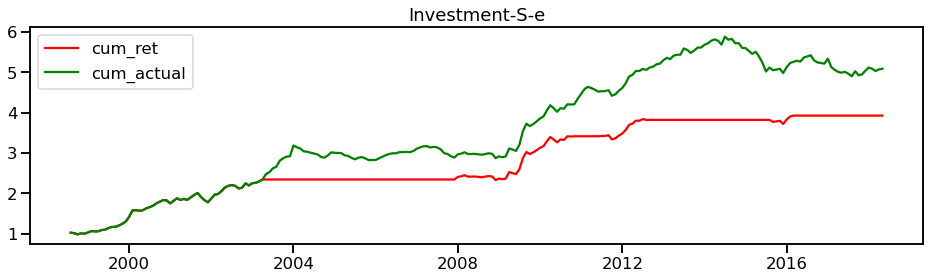

In [82]:
plot_strat_vs_BnH(SPY_ret,INeL,"1998-07-01","2018-05-01")

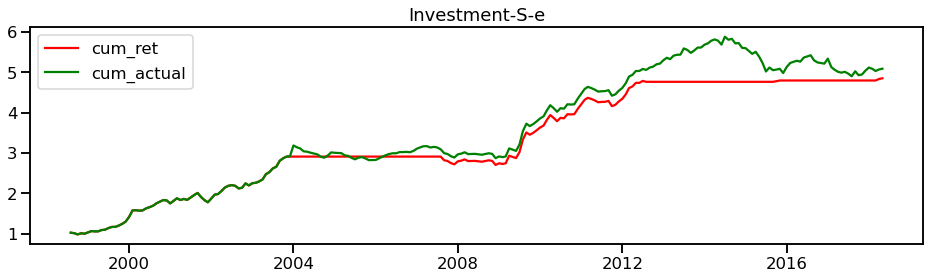

In [83]:
plot_strat_vs_BnH(VIX,INeL,"1998-07-01","2018-05-01")

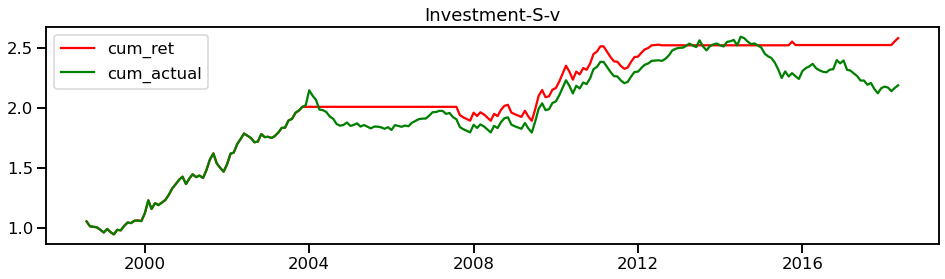

In [84]:
plot_strat_vs_BnH(VIX,INvL,"1998-07-01","2018-05-01")

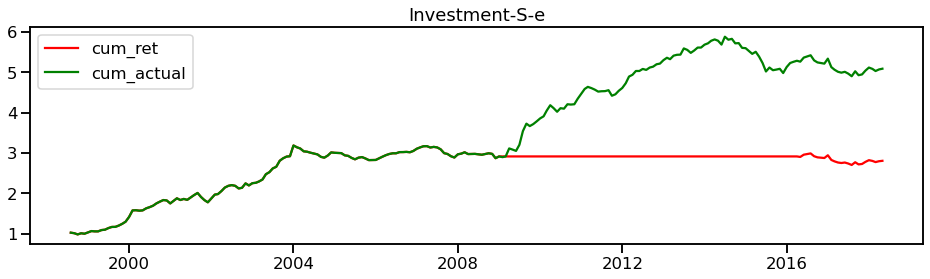

In [85]:
plot_strat_vs_BnH(DFF,INeL,"1998-07-01","2018-05-01")

# <font color = "blue"> 4) Test set results

In [86]:
BnH_results_test

,BnH Sharpe,BnH CAGR,BnH Volatility
Investment-S-e,1.032395,0.106889,0.089197
Operating_Profitability-B-e,0.737776,0.082474,0.095549
Operating_Profitability-B-v,0.717541,0.082924,0.100148
Prior_Month_Return-S-e,0.473549,0.081072,0.163654
Prior_Month_Return-S-v,0.433697,0.065593,0.136857
Investment-S-v,0.417977,0.049643,0.094862
12_1_Momentum-S-e,0.379591,0.065432,0.174378
Book_to_Market-S-e,0.316560,0.051890,0.153791
Operating_Profitability-S-v,0.301619,0.043654,0.122537
12_1_Momentum-S-v,0.261504,0.041382,0.146909


In [87]:
# the 4 portoflios chosen are: 
### INeL: VIX, SPY_ret, DFF
### INvL: VIX

In [88]:
def getmarkovregime(df, start,end): #training set end to testing set end 
    #this function is to produce trading signals
    df1 = df.copy()
    df1 = df1.loc[start:end]
    model = MarkovRegression(df1, k_regimes=2, switching_variance=True).fit()
    regime = model.smoothed_marginal_probabilities.values.argmax(axis=1)
         #regime classification not forward predictions
         # 0 is good state, 1 is bad state 

    frame = pd.DataFrame(regime, index = df1.index, columns = ["State"])    
    return frame      

In [89]:
def get_PnL_testset(regress_inst,trade_inst, start_train, end_test, start_test): #including commissions
    #start = start of train, end = end of test, start_test = start of test
    fee = 10/100/100  #10bps
    trade_inst1 = trade_inst.copy()
    results_df = pd.DataFrame()
    results_df["states"] = getmarkovregime(regress_inst, start_train,end_test).loc[start_test:] #this is to ensure only P&L from test set
    results_df["positions"] = results_df["states"].shift(1)
    results_df["execution"] = results_df["positions"].diff()
    results_df["actual_ret"] = trade_inst1.loc[start_test:] 
    results_df["strat_ret"] = results_df["actual_ret"]*results_df["positions"]
    results_df["net_strat_ret"] = 0.0
    
    for i in range(len(results_df.index)):
        if results_df["execution"][i] == 1:
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i] - fee
        elif results_df["execution"][i] == -1:
            results_df["net_strat_ret"][i-1] = results_df["strat_ret"][i-1] - fee 
        else:
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i]        
    if results_df["positions"][1] == 1:
        results_df["execution"][1] = 1 
        results_df["net_strat_ret"][1] = results_df["net_strat_ret"][1]-fee
            
    results_df["cum_ret"] = (1+results_df["net_strat_ret"].dropna()).cumprod()

    return results_df

In [90]:
def get_PnL_LS_testset(regress_inst,trade_inst, start_train, end_test, start_test): #including commissions
    #start = start of train, end = end of test, start_test = start of test
    fee = 10/100/100  #10bps
    trade_inst1 = trade_inst.copy()
    results_df = pd.DataFrame()
    results_df["states"] = getmarkovregime(regress_inst, start_train,end_test).loc[start_test:] #this is to ensure only P&L from test set
    results_df["positions"] = results_df["states"].shift(1).replace([0,1],[1,-1])
    results_df["execution"] = results_df["positions"].diff()
    results_df["actual_ret"] = trade_inst1.loc[start_test:] 
    results_df["strat_ret"] = results_df["actual_ret"]*results_df["positions"]
    results_df["net_strat_ret"] = 0.0
    
    for i in range(len(results_df.index)):
        if results_df["execution"][i] == -2: #long change to short position
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i] - 2*fee
            
        elif results_df["execution"][i] == 2: #short change to long position
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i] - 2*fee
            
        else:
            results_df["net_strat_ret"][i] = results_df["strat_ret"][i]        
    if results_df["positions"][1] == 1:
        results_df["net_strat_ret"][1] = results_df["net_strat_ret"][1]-fee
        
    elif results_df["positions"][1] == -1:
        results_df["net_strat_ret"][1] = results_df["net_strat_ret"][1]-fee 
            
    results_df["cum_ret"] = (1+results_df["net_strat_ret"].dropna()).cumprod()

    return results_df

In [91]:
# get_PnL_testset(SPY_ret, INeL, "1998-07-01", "2023-03-01","2018-05-01")

In [92]:
def key_stats(df):
    df1 = df.copy()
    df2 = rfr.copy()
    df2 = df2[df2.index.isin(df1.index)]
    CAGR = ((df1["cum_ret"][-1])**(12/(len(df1)-1)))-1
    sharpe = ((df1["strat_ret"] - df2).dropna().mean()/ (df1["strat_ret"] - df2).dropna().std())*np.sqrt(12)
    volatility = df1["strat_ret"].std()*np.sqrt(12)
    key = [sharpe,CAGR,volatility]
    stats = pd.DataFrame(key, index = ["Strat Sharpe","Strat CAGR","Strat Volatility"], columns = ["strat"])
    return stats

In [93]:
def get_strat_results_test(dfs, regress_inst, start_train, end_test, start_test):
    bigsmall_list = []
    for count,i in enumerate(dfs):
        bigsmall = []
        big = key_stats(get_PnL_testset(regress_inst, i.iloc[:,0],start_train, end_test, start_test))
        small = key_stats(get_PnL_testset(regress_inst, i.iloc[:,1],start_train, end_test, start_test))
        bigsmall.append(big)
        bigsmall.append(small)
        bigsmall_df = pd.concat(bigsmall, axis = 1)
        bigsmall_df.columns = dfs[count].columns
        bigsmall_list.append(bigsmall_df)
        bigsmall_list_df = pd.concat(bigsmall_list, axis = 1).T
        
    return bigsmall_list_df.sort_values(by = "Strat Sharpe", ascending = False)

In [94]:
def get_strat_results_test_LS(dfs, regress_inst, start_train, end_test, start_test):
    bigsmall_list = []
    for count,i in enumerate(dfs):
        bigsmall = []
        big = key_stats(get_PnL_LS_testset(regress_inst, i.iloc[:,0],start_train, end_test, start_test))
        small = key_stats(get_PnL_LS_testset(regress_inst, i.iloc[:,1],start_train, end_test, start_test))
        bigsmall.append(big)
        bigsmall.append(small)
        bigsmall_df = pd.concat(bigsmall, axis = 1)
        bigsmall_df.columns = dfs[count].columns
        bigsmall_list.append(bigsmall_df)
        bigsmall_list_df = pd.concat(bigsmall_list, axis = 1).T
        
    return bigsmall_list_df.sort_values(by = "Strat Sharpe", ascending = False)

In [95]:
get_strat_results_test_LS(portfolios, DFF,"1998-07-01","2023-03-01","2018-05-01").head()

,Strat Sharpe,Strat CAGR,Strat Volatility
Book_to_Market-S-v,1.331569,0.222688,0.150930
60_13_Momentum-B-v,1.254342,0.222762,0.162706
Book_to_Market-S-e,1.219032,0.194951,0.144809
Book_to_Market-B-e,1.173317,0.201629,0.157557
Investment-B-e,1.062831,0.125283,0.104698


In [96]:
get_strat_results_test_LS(portfolios, oilprc,"1998-07-01","2023-03-01","2018-05-01")

,Strat Sharpe,Strat CAGR,Strat Volatility
Cashflow_to_Price-B-v,0.351889,0.054529,0.143958
12_1_Momentum-B-v,0.269006,0.047831,0.195918
Earning_to_Price-B-v,0.195709,0.032205,0.163016
Dividend_Yield-B-v,0.141255,0.023054,0.134916
Book_to_Market-B-v,0.087322,0.012435,0.182461
Earning_to_Price-B-e,0.066055,0.013244,0.129010
Earning_to_Price-S-v,0.057146,0.013035,0.113567
Cashflow_to_Price-B-e,0.044550,0.010141,0.133291
12_1_Momentum-B-e,0.037680,0.005682,0.165041
Earning_to_Price-S-e,0.026458,0.010648,0.098189


In [97]:
BnH_results_test.describe()

,BnH Sharpe,BnH CAGR,BnH Volatility
count,36.000000,36.000000,36.000000
mean,0.065026,0.009245,0.134914
std,0.357259,0.046912,0.032633
min,-0.549256,-0.073302,0.062219
25%,-0.244112,-0.025109,0.111925
50%,0.072159,0.015138,0.135307
75%,0.271533,0.041950,0.162551
max,1.032395,0.106889,0.195463


In [98]:
get_strat_results_test_LS(portfolios, SPY_ret,"1998-07-01","2023-03-01","2018-05-01")

,Strat Sharpe,Strat CAGR,Strat Volatility
Prior_Month_Return-B-v,0.247180,0.037660,0.150791
Dividend_Yield-S-v,0.199897,0.023684,0.080831
Cashflow_to_Price-S-v,0.182552,0.025473,0.113539
Earning_to_Price-B-v,0.114044,0.016664,0.163278
Book_to_Market-S-v,0.101240,0.014084,0.163157
Earning_to_Price-B-e,0.065514,0.011248,0.129010
Prior_Month_Return-B-e,0.051433,0.008617,0.134889
Earning_to_Price-S-v,-0.001645,0.004329,0.113646
Book_to_Market-B-v,-0.005567,-0.006374,0.182621
Dividend_Yield-B-v,-0.028406,-0.002048,0.135211


In [99]:
get_strat_results_test(portfolios, oilprc,"1998-07-01","2023-03-01","2018-05-01").describe()

,Strat Sharpe,Strat CAGR,Strat Volatility
count,36.000000,36.000000,36.000000
mean,0.076876,0.010379,0.135712
std,0.357808,0.047296,0.032808
min,-0.529160,-0.081936,0.062724
25%,-0.208877,-0.026252,0.112740
50%,0.084697,0.016560,0.136483
75%,0.276320,0.043183,0.163746
max,1.036601,0.107784,0.195918


In [100]:
get_strat_results_test(portfolios, VIX,"1998-07-01","2023-03-01","2018-05-01")

,Strat Sharpe,Strat CAGR,Strat Volatility
Investment-S-e,0.992301,0.096198,0.083333
Operating_Profitability-S-v,0.790461,0.085341,0.093143
Cashflow_to_Price-S-e,0.746279,0.074732,0.083469
Operating_Profitability-B-e,0.703540,0.069446,0.082462
Book_to_Market-S-e,0.653598,0.089210,0.122405
60_13_Momentum-S-v,0.607114,0.078125,0.112892
60_13_Momentum-B-e,0.597453,0.077132,0.113666
60_13_Momentum-S-e,0.591889,0.099644,0.159051
Cashflow_to_Price-B-e,0.581832,0.061728,0.087300
60_13_Momentum-B-v,0.571967,0.088105,0.143375


In [101]:
get_strat_results_test(portfolios, SPY_ret,"1998-07-01","2023-03-01","2018-05-01").describe()

,Strat Sharpe,Strat CAGR,Strat Volatility
count,36.000000,36.000000,36.000000
mean,0.044784,0.009162,0.120606
std,0.328200,0.037685,0.030806
min,-0.366789,-0.048007,0.055905
25%,-0.241236,-0.022946,0.094298
50%,-0.001635,0.006822,0.125007
75%,0.223157,0.032937,0.143429
max,1.067867,0.105085,0.177213


In [102]:
BMs = [BMvH,BMvL,BMeH,BMeL]
CPs = [CPvH,CPvL,CPeH,CPeL]
DPs = [DPvH,DPvL,DPeH,DPeL]
EPs = [EPvH,EPvL,EPeH,EPeL]
OPs= [OPvH,OPvL,OPeH,OPeL]
INvs = [INvH,INvL,INeH,INeL]
PRs = [PRvH,PRvL,PReH,PReL]
SMs = [SMvH,SMvL,SMeH,SMeL]
LMs = [LMvH,LMvL,LMeH,LMeL]

In [103]:
def autoregresshead(ports):
    regress_list = []
    for i in ports:
        regress = get_strat_results_test(portfolios,i,"1998-07-01","2023-03-01","2018-05-01").head()
        regress_list.append(regress)
        regress_df = pd.concat(regress_list)
    return regress_df    

In [104]:
def autoregresshead_LS(ports):
    regress_list = []
    for i in ports:
        regress = get_strat_results_test_LS(portfolios,i,"1998-07-01","2023-03-01","2018-05-01").head()
        regress_list.append(regress)
        regress_df = pd.concat(regress_list)
    return regress_df    

In [105]:
def best_autoregress_test(list_of, strat_type):
    trial1_list = []

    for K in list_of:
        if strat_type == "Long":
            trial1 = autoregresshead(K)
            trial1_list.append(trial1)
            trial1_list_df = pd.concat(trial1_list, axis =0).sort_values(by = "Strat Sharpe", ascending = False).head(36)  
        if strat_type == "LS":
            trial1 = autoregresshead_LS(K)
            trial1_list.append(trial1)
            trial1_list_df = pd.concat(trial1_list, axis =0).sort_values(by = "Strat Sharpe", ascending = False).head(36)              
        
    return trial1_list_df

In [106]:
# best_autoregress_test([BMs, CPs, DPs, OPs, INvs, PRs, SMs, LMs], "Long")

In [107]:
# best_autoregress_test([BMs, CPs, DPs, OPs, INvs, PRs, SMs, LMs], "Long").describe()

In [108]:
# best_autoregress_test([BMs, CPs, DPs, OPs, INvs, PRs, SMs, LMs], "LS").describe()

In [109]:
# best_autoregress_test([BMs, CPs, DPs, OPs, INvs, PRs, SMs, LMs], "LS")

In [110]:
# autoregresshead(EPs)

In [111]:
# autoregresshead(CPs)

In [112]:
# autoregresshead(DPs)

In [113]:
# autoregresshead(OPs)

In [114]:
autoregresshead(INvs)

,Strat Sharpe,Strat CAGR,Strat Volatility
Operating_Profitability-B-e,0.823737,0.070504,0.069558
Investment-B-e,0.675513,0.068723,0.083791
Investment-S-e,0.601050,0.049982,0.063138
Operating_Profitability-S-e,0.570915,0.069487,0.104473
60_13_Momentum-B-v,0.528670,0.076850,0.131070
Investment-S-e,1.068772,0.104762,0.084105
Book_to_Market-S-e,0.941095,0.134295,0.127973
Cashflow_to_Price-S-e,0.806862,0.065262,0.063493
Operating_Profitability-S-v,0.750734,0.086845,0.100140
Operating_Profitability-B-e,0.743644,0.078246,0.088906


In [115]:
def diff_in(strategy,actual,method):
    diffs = pd.DataFrame()
    diffs_list = []
    strategy1 = strategy.copy()
    actual1 = actual.copy()
    filtered_df = pd.DataFrame()
    if method == "sharpe":   
        strategy_plus = strategy1[strategy1["Strat Sharpe"] > 0]
        actual2 = actual1[actual1.index.isin(strategy_plus.index)]
                         
        names = ["Sharpe","CAGR","Volatility"]
        for count, i in enumerate(names):
            diffs = strategy_plus.iloc[:,count] - actual2.iloc[:,count]
            diffs_list.append(diffs)
            diffs_df = pd.concat(diffs_list, axis = 1)
        diffs_df.columns = names

        filtered_df = diffs_df[diffs_df["Sharpe"] > 0]
        
    elif method == "cagr":   
        strategy_plus = strategy1[strategy1["Strat CAGR"] > 0]
        actual2 = actual1[actual1.index.isin(strategy_plus.index)]
                         
        names = ["Sharpe","CAGR","Volatility"]
        for count, i in enumerate(names):
            diffs = strategy_plus.iloc[:,count] - actual2.iloc[:,count]
            diffs_list.append(diffs)
            diffs_df = pd.concat(diffs_list, axis = 1)
        diffs_df.columns = names

        filtered_df = diffs_df[diffs_df["CAGR"] > 0]
                         
#     print("the portfolios that beat the buy-and-hold SHARPE are:",beat_sharpes)
#     print("the portfolios that beat the buy-and-hold CAGR are:",beat_cagr)
#     print("the portfolios that beat the buy-and-hold Volatility are:",beat_vol)
    
    return filtered_df.sort_values(by = "Sharpe", ascending = False)

In [116]:
def plot_strat_vs_BnH_test(regress_inst,trade_inst,train_start,test_end,test_start): #, regress_title,trade_title):
    pnl_df = get_PnL_testset(regress_inst,trade_inst,train_start,test_end,test_start)
    pnl_df.dropna(inplace=True)
    pnl_df['cum_strat'] = (1 + pnl_df['strat_ret']).cumprod()
    pnl_df['cum_actual'] = (1 + pnl_df['actual_ret']).cumprod()
    title = trade_inst.name
    plt.figure(figsize=(16,4))
    plt.plot(pnl_df.iloc[:,-2], color = 'r')
    plt.plot(pnl_df.iloc[:,-1], color = 'g')
    plt.legend(labels=['cum_ret','cum_actual'],loc='best')
    plt.title(title)
    plt.show()

In [117]:
def plot_strat_comparision(df):
    pnl_df = df.copy()
    pnl_df['cum_actual'] = (1 + pnl_df['actual_ret']).cumprod()
    plt.figure(figsize=(8,4))
    plt.plot(pnl_df.iloc[:,-2], color = 'r',label = "Strategy")
    plt.plot(pnl_df.iloc[:,-1], color = 'g', label = "buy-and-hold Famma French Ports")
    SPY_test = SPY_ret[SPY_ret.index.isin(pnl_df.index)]
    plt.plot((1+SPY_test).cumprod(), color = 'b', label = "SPY")
    plt.legend(fontsize = 10)
    plt.xlabel("time horizon")
    plt.ylabel("cummulative returns")
    plt.show()

### 4b) 1st part is looking at which portfolio out of 36 in test set beat buy and hold

In [118]:
print("the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is:",len(diff_in(get_strat_results_test(portfolios, SPY_ret,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe"))/36)
diff_in(get_strat_results_test(portfolios, SPY_ret,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe")

the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is: 0.2222222222222222


,Sharpe,CAGR,Volatility
60_13_Momentum-B-v,0.255159,0.043916,-0.019513
Investment-B-v,0.244445,0.027678,-0.011552
Investment-B-e,0.211051,0.018040,-0.015691
12_1_Momentum-B-e,0.156954,0.026667,-0.015540
60_13_Momentum-S-e,0.154718,0.027287,-0.010512
60_13_Momentum-S-v,0.125982,0.017228,-0.013381
Prior_Month_Return-S-e,0.090401,0.011878,-0.006654
Investment-S-e,0.035472,-0.001804,-0.003810


In [119]:
print("the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is:",len(diff_in(get_strat_results_test_LS(portfolios, SPY_ret,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe"))/36)
diff_in(get_strat_results_test_LS(portfolios, SPY_ret,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe").median()

the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is: 0.16666666666666666


Sharpe        0.344108
CAGR          0.045913
Volatility    0.000555
dtype: float64

In [120]:
print("the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is:",len(diff_in(get_strat_results_test(portfolios, VIX,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe"))/36)
diff_in(get_strat_results_test(portfolios, VIX,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe")

the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is: 0.6111111111111112


,Sharpe,CAGR,Volatility
Cashflow_to_Price-B-e,0.857337,0.093934,-0.045292
Earning_to_Price-B-e,0.715300,0.081400,-0.037015
60_13_Momentum-B-e,0.715127,0.093153,-0.037537
Cashflow_to_Price-B-v,0.710504,0.097309,-0.038136
60_13_Momentum-B-v,0.705837,0.112472,-0.029917
Earning_to_Price-S-v,0.676733,0.066852,-0.035113
Book_to_Market-B-e,0.625184,0.090978,-0.043131
60_13_Momentum-S-v,0.618993,0.076332,-0.027912
Book_to_Market-B-v,0.607156,0.101649,-0.047873
Cashflow_to_Price-S-e,0.569812,0.047347,-0.030388


In [121]:
print("the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is:",len(diff_in(get_strat_results_test_LS(portfolios, VIX,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe"))/36)
diff_in(get_strat_results_test_LS(portfolios, VIX,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe").median()

the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is: 0.08333333333333333


Sharpe        0.486240
CAGR          0.079377
Volatility   -0.000980
dtype: float64

In [122]:
print("the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is:",len(diff_in(get_strat_results_test(portfolios, DFF,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe"))/36)
diff_in(get_strat_results_test(portfolios, DFF,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe").median()

the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is: 0.05555555555555555


Sharpe        0.062172
CAGR          0.009187
Volatility   -0.018059
dtype: float64

In [123]:
print("the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is:",len(diff_in(get_strat_results_test_LS(portfolios, DFF,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe"))/36)
diff_in(get_strat_results_test_LS(portfolios, DFF,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe")

the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is: 0.7222222222222222


,Sharpe,CAGR,Volatility
Cashflow_to_Price-B-v,1.586104,0.228628,-0.004888
Book_to_Market-S-v,1.536904,0.255420,-0.011254
60_13_Momentum-B-v,1.388211,0.247128,-0.010586
Dividend_Yield-B-v,1.349136,0.182822,-0.005180
Book_to_Market-B-v,1.315207,0.245803,-0.008002
Book_to_Market-B-e,1.301015,0.223606,-0.008943
Earning_to_Price-B-e,1.252579,0.162451,-0.004910
Cashflow_to_Price-B-e,1.230371,0.165300,-0.005052
60_13_Momentum-B-e,1.172874,0.181717,-0.006477
Earning_to_Price-B-v,1.131443,0.185702,-0.002877


In [124]:
print("the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is:",len(diff_in(get_strat_results_test(portfolios, oilprc,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe"))/36)
diff_in(get_strat_results_test(portfolios, oilprc,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe").median()

the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is: 0.3055555555555556


Sharpe        0.018799
CAGR          0.001611
Volatility    0.000701
dtype: float64

In [125]:
print("the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is:",len(diff_in(get_strat_results_test_LS(portfolios, oilprc,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe"))/36)
diff_in(get_strat_results_test_LS(portfolios, oilprc,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe").median()

the proportion of portfolios of out the 36 FF portfolios that have positive sharpe and beats the buy-and-hold base case is: 0.3055555555555556


Sharpe        0.359609
CAGR          0.047908
Volatility    0.000846
dtype: float64

In [126]:
def autoregressdiff(fammaboys, method):
    proportion_list = []
    for i in fammaboys:
        if method == "Long":
            sets = diff_in(get_strat_results_test(portfolios, i,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe")
            proportion = (len(sets)/36)
            proportion_list.append(proportion)
            proportion_list_df = pd.DataFrame(proportion_list)
        elif method == "LS":
            sets = diff_in(get_strat_results_test_LS(portfolios, i,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe")
            proportion = (len(sets)/36)
            proportion_list.append(proportion)
            proportion_list_df = pd.DataFrame(proportion_list)       
        
    proportion_list_df.index = [K.name for K in fammaboys]
    proportion_list_df.columns = ["proportion of winners"]
    proportion_list_df = proportion_list_df.sort_values(by = "proportion of winners", ascending = False)    
        
    return proportion_list_df

In [127]:
def autoregressdiffrange(fammaboys, method):
    sets_list = []
    for i in fammaboys:
        if method == "Long":
            sets = diff_in(get_strat_results_test(portfolios, i,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe")
            sets_list.append(sets)
            sets_list_df = pd.concat(sets_list, axis = 0)
            range_value = sets_list_df.median()

        elif method == "LS":
            sets = diff_in(get_strat_results_test_LS(portfolios, i,"1998-07-01","2023-03-01","2018-05-01"),BnH_results_test,"sharpe")
            sets_list.append(sets)
            sets_list_df = pd.concat(sets_list, axis = 0)
            range_value = sets_list_df.median()  
                
    return median_value

In [128]:
new_ports = [BMvH,BMvL,BMeH,BMeL,CPvH,CPvL,CPeH,CPeL,DPvH,DPvL,\
             DPeH,DPeL,EPvH,EPvL,EPeH,EPeL,OPvH,OPvL,OPeH,OPeL,\
             INvH,INvL,INeH,INeL,PRvH,PRvL,PReH,PReL,SMvH,SMvL,\
             SMeH,SMeL,LMvH,LMvL,LMeH,LMeL]

In [129]:
SMvL

1963-07-01    0.0026
1963-08-01    0.0227
1963-09-01    0.0060
1963-10-01    0.0247
1963-11-01    0.0091
               ...  
2022-11-01    0.0056
2022-12-01    0.0225
2023-01-01   -0.1382
2023-02-01    0.0305
2023-03-01    0.0167
Name: 12_1_Momentum-S-v, Length: 717, dtype: float64

In [130]:
INeL

1963-07-01   -0.007777
1963-08-01    0.012544
1963-09-01    0.008518
1963-10-01    0.003089
1963-11-01    0.010058
                ...   
2022-11-01    0.035155
2022-12-01    0.048584
2023-01-01   -0.029956
2023-02-01   -0.008119
2023-03-01    0.014143
Name: Investment-S-e, Length: 717, dtype: float64

In [131]:
PReL

1963-07-01    0.0191
1963-08-01    0.0092
1963-09-01    0.0265
1963-10-01    0.0111
1963-11-01    0.0140
               ...  
2022-11-01   -0.0174
2022-12-01   -0.0232
2023-01-01    0.1591
2023-02-01    0.0362
2023-03-01   -0.0448
Name: Prior_Month_Return-S-e, Length: 717, dtype: float64

In [132]:
DPeL

1963-07-01    0.0132
1963-08-01   -0.0222
1963-09-01    0.0043
1963-10-01   -0.0125
1963-11-01    0.0117
               ...  
2022-11-01   -0.0111
2022-12-01    0.0076
2023-01-01    0.0067
2023-02-01   -0.0126
2023-03-01   -0.0316
Name: Dividend_Yield-S-e, Length: 717, dtype: float64

In [133]:
# autoregressdiffmedian(new_ports, "Long")

In [134]:
# autoregressdiffmedian(new_ports, "LS")

In [135]:
# autoregressdiff(new_ports, "Long")

In [136]:
# autoregressdiff(new_ports, "LS")

In [137]:
# new_ports

In [138]:
def plotbnH(dfs):
    frames = dfs.copy()
    plt.figure(figsize = (16,8))  
    for i in frames:
        bnhcumrets = (1 + i.loc["2018-05-01":]).cumprod()
        plt.plot(bnhcumrets.index, bnhcumrets, label = i.name)

    plt.legend(loc = "lower left", fontsize = 12)  
    plt.title("Famma French Buy-and-Hold cummulative returns")
    plt.ylabel("cummulative returns")
    plt.xlabel("testing set dates")
    plt.show()    

In [139]:
def plotbnHvalid(dfs):
    frames = dfs.copy()
    plt.figure(figsize = (16,8))  
    for i in frames:
        bnhcumrets = (1 + i.loc["2013-05-01":"2018-04-01"]).cumprod()
        plt.plot(bnhcumrets.index, bnhcumrets, label = i.name)

    plt.legend(loc = "lower left", fontsize = 12)  
    plt.title("Famma French Buy-and-Hold cummulative returns")
    plt.ylabel("cummulative returns")
    plt.xlabel("testing set dates")
    plt.show()    

In [140]:
def corrasses(dfs):
    frames = dfs.copy()
    frames_list = []
    for i in dfs:
        frames_list.append(i.loc["2018-05-01":]) 
        frames_df = pd.concat(frames_list, axis =1).corr().mean()
#     frames_df.index =  [K.name for K in frames]
#     frames_df.columns =  [K.name for K in frames]
    
    return frames_df

In [141]:
new_ports[0]

1963-07-01   -0.018143
1963-08-01    0.023484
1963-09-01   -0.007856
1963-10-01   -0.017112
1963-11-01    0.009321
                ...   
2022-11-01   -0.002919
2022-12-01    0.022289
2023-01-01   -0.023248
2023-02-01   -0.023279
2023-03-01   -0.120143
Name: Book_to_Market-B-v, Length: 717, dtype: float64

In [142]:
def BnH_stats_combined(df):
    df1 = df.copy()
    df2 = rfr.copy()
    frames_list = []
    for i in df1:
        frames_list.append(i.loc["2018-05-01":])
        frames_df = pd.concat(frames_list, axis =1).mean(axis =1)
        cum_ret = (1+frames_df).cumprod()
    df2 = df2[df2.index.isin(frames_df.index)]
    CAGR = ((cum_ret[-1])**(12/(len(frames_df))))-1
    sharpe = ((frames_df - df2).dropna().mean()/ (frames_df - df2).dropna().std())*np.sqrt(12)
    volatility = frames_df.std()*np.sqrt(12)
    key = [sharpe,CAGR,volatility]
    stats = pd.DataFrame(key, index = ["Strat Sharpe","Strat CAGR","Strat Volatility"], columns = ["strat"])
    return stats

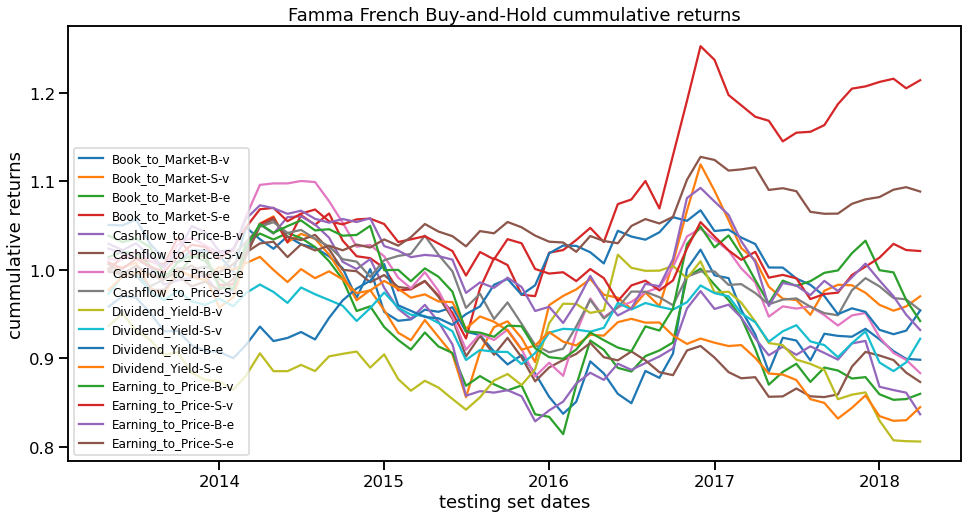

In [143]:
plotbnHvalid(new_ports[0:16])

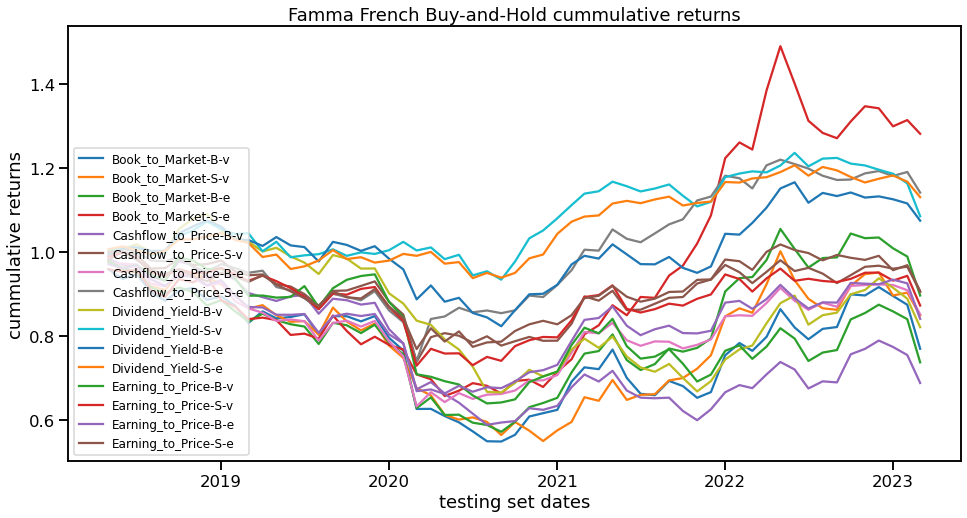

In [144]:
plotbnH(new_ports[0:16])

In [145]:
corrasses(new_ports[0:16])
#average pairwise correlation for...
#...valuation multiple basket returns

Book_to_Market-B-v       0.764493
Book_to_Market-S-v       0.686306
Book_to_Market-B-e       0.800959
Book_to_Market-S-e       0.623806
Cashflow_to_Price-B-v    0.747039
Cashflow_to_Price-S-v    0.700499
Cashflow_to_Price-B-e    0.781062
Cashflow_to_Price-S-e    0.650503
Dividend_Yield-B-v       0.662068
Dividend_Yield-S-v       0.533407
Dividend_Yield-B-e       0.745978
Dividend_Yield-S-e       0.477885
Earning_to_Price-B-v     0.749905
Earning_to_Price-S-v     0.749508
Earning_to_Price-B-e     0.789692
Earning_to_Price-S-e     0.704705
dtype: float64

In [146]:
BnH_stats_combined(new_ports[0:16])

,strat
Strat Sharpe,-0.203414
Strat CAGR,-0.015181
Strat Volatility,0.109043


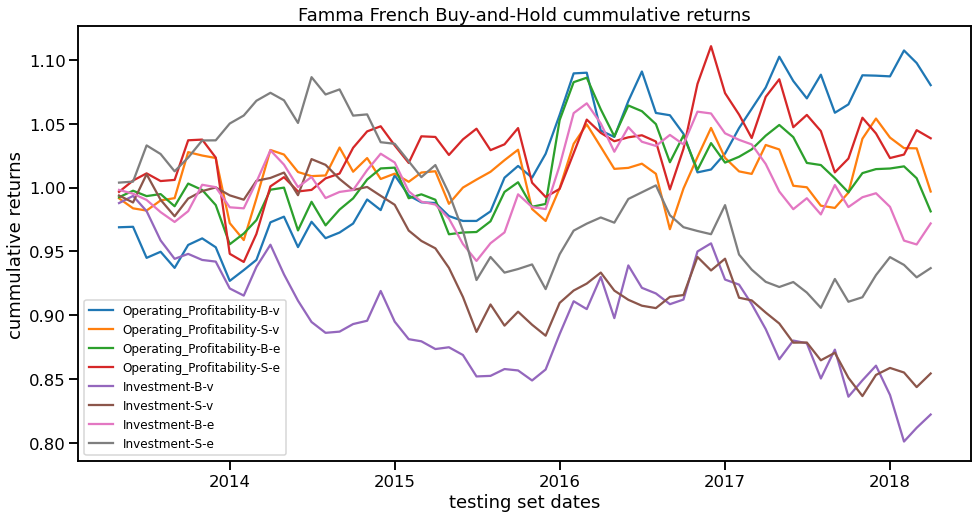

In [147]:
plotbnHvalid(new_ports[16:24])

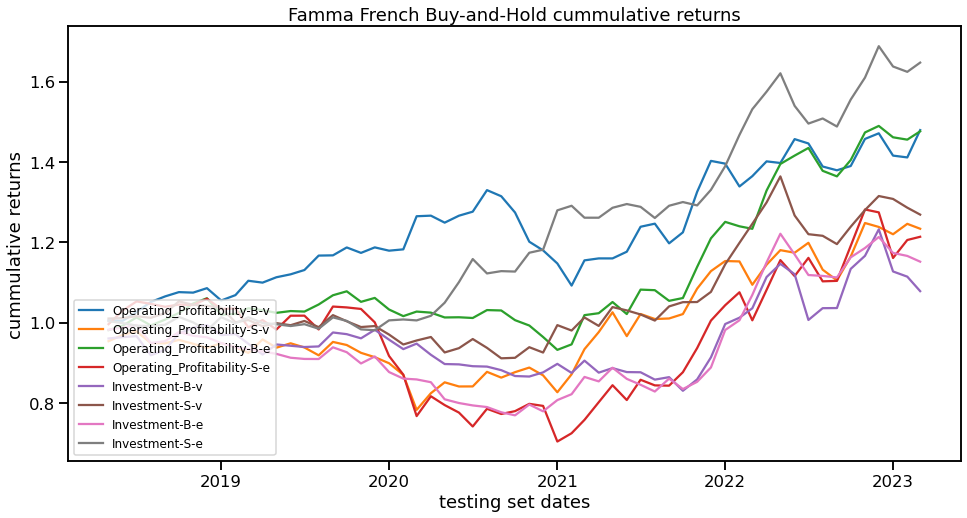

In [148]:
plotbnH(new_ports[16:24])

In [149]:
corrasses(new_ports[16:24])
#average pairwise correlation for balance sheet/income..
#..statement items (non valuation) basket returns

Operating_Profitability-B-v    0.236098
Operating_Profitability-S-v    0.405157
Operating_Profitability-B-e    0.511004
Operating_Profitability-S-e    0.426012
Investment-B-v                 0.501593
Investment-S-v                 0.453987
Investment-B-e                 0.538305
Investment-S-e                 0.291394
dtype: float64

In [150]:
BnH_stats_combined(new_ports[16:24])

,strat
Strat Sharpe,0.640795
Strat CAGR,0.059930
Strat Volatility,0.074078


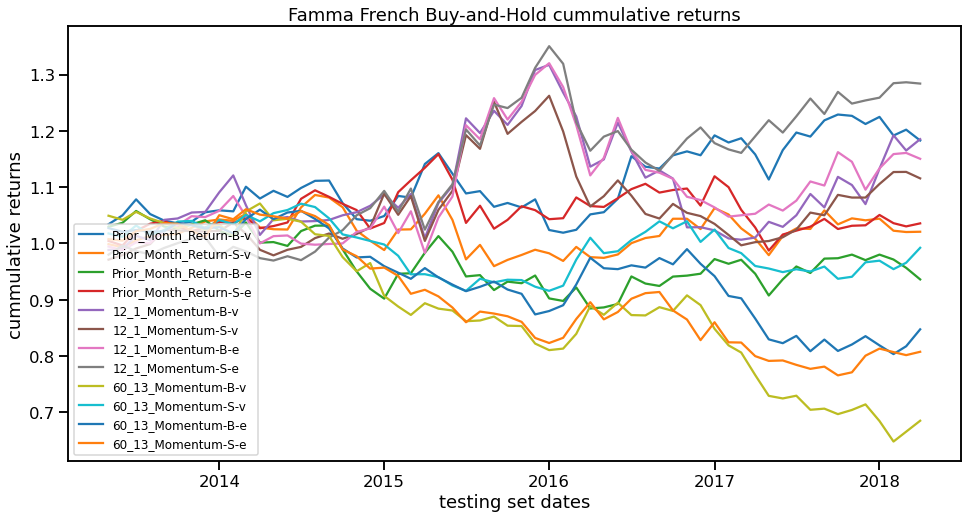

In [151]:
plotbnHvalid(new_ports[24:36])

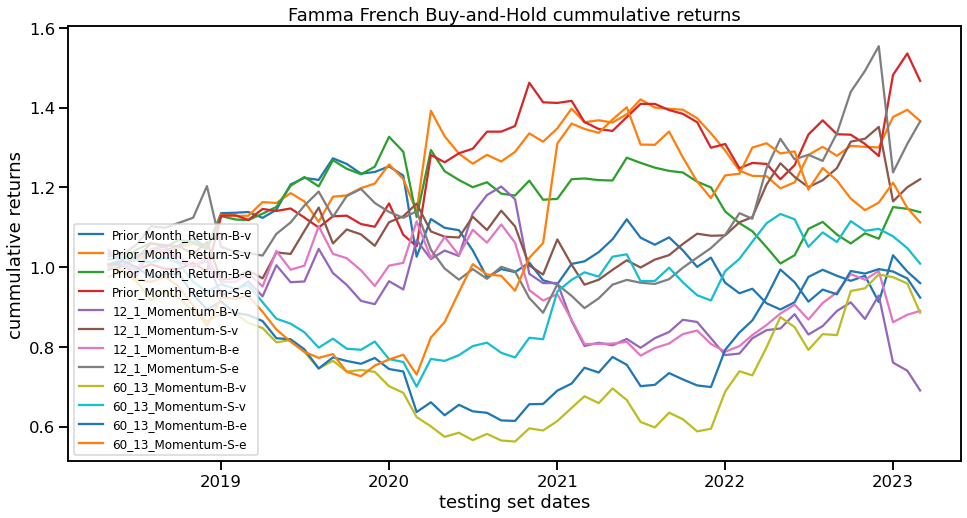

In [152]:
plotbnH(new_ports[24:36])

In [153]:
corrasses(new_ports[24:36])
#average pairwise correlation for...
#...momentum basket returns

Prior_Month_Return-B-v    0.132948
Prior_Month_Return-S-v    0.183696
Prior_Month_Return-B-e    0.160536
Prior_Month_Return-S-e    0.145196
12_1_Momentum-B-v         0.036975
12_1_Momentum-S-v         0.088164
12_1_Momentum-B-e         0.026351
12_1_Momentum-S-e         0.052023
60_13_Momentum-B-v        0.193718
60_13_Momentum-S-v        0.306029
60_13_Momentum-B-e        0.245768
60_13_Momentum-S-e        0.251516
dtype: float64

In [154]:
BnH_stats_combined(new_ports[24:36])

,strat
Strat Sharpe,0.192765
Strat CAGR,0.023373
Strat Volatility,0.061071


### 4b) Choosing the winners from the training set, allocating weights and constructing a combined portoflio and carrying it over to the testing set to beat buy-and-hold famma french

In [155]:
port1_train = get_PnL(VIX, INeL, "1998-07-01","2018-05-01")
port2_train = get_PnL(SPY_ret, INeL, "1998-07-01","2018-05-01")
port3_train = get_PnL_LS(SMvL, DPvH, "1998-07-01","2018-05-01") #LONG SHORT
port4_train = get_PnL_LS(PReL, OPeH, "1998-07-01","2018-05-01") #LONG SHORT
port5_train = get_PnL_LS(DFF, BMvL, "1998-07-01","2018-05-01") #LONG SHORT
port6_train = get_PnL(CPeL, INeL, "1998-07-01","2018-05-01")
port7_train = get_PnL_LS(DFF, LMvH, "1998-07-01","2018-05-01") #LONG SHORT
port8_train = get_PnL(DPeL, INeL, "1998-07-01","2018-05-01")

combined_port_train = pd.concat([port1_train.loc[:,"net_strat_ret"],port2_train.loc[:,"net_strat_ret"],\
                                 port3_train.loc[:,"net_strat_ret"],\
                           port4_train.loc[:,"net_strat_ret"],port5_train.loc[:,"net_strat_ret"],\
                                 port6_train.loc[:,"net_strat_ret"],\
                          port7_train.loc[:,"net_strat_ret"],\
                                 port8_train.loc[:,"net_strat_ret"]], axis = 1)

combined_port_train.columns = ["port1","port2","port3","port4", "port5", "port6", "port7","port8"]
combined_port_train.head()

,port1,port2,port3,port4,port5,port6,port7,port8
1998-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-01,0.025331,0.025331,0.0933,0.019272,-0.056635,0.000000,-0.0497,0.025331
1998-09-01,-0.012778,-0.012778,0.0444,0.050886,0.054581,-0.013778,-0.0218,-0.012778
1998-10-01,-0.029681,-0.029681,-0.0597,-0.037321,0.010833,-0.030681,0.0430,-0.029681
1998-11-01,0.028972,0.028972,-0.0419,0.002936,0.035162,0.000000,0.0340,0.028972


In [156]:
combined_port_train.corr()

,port1,port2,port3,port4,port5,port6,port7,port8
port1,1.000000,0.922252,-0.038061,-0.179219,0.076986,0.841675,-0.081915,0.963196
port2,0.922252,1.000000,-0.026227,-0.135084,0.098164,0.873039,-0.079943,0.938308
port3,-0.038061,-0.026227,1.000000,0.336543,0.292989,-0.065100,-0.003008,-0.053220
port4,-0.179219,-0.135084,0.336543,1.000000,0.579134,-0.159222,0.141893,-0.182757
port5,0.076986,0.098164,0.292989,0.579134,1.000000,0.104277,0.350618,0.095291
port6,0.841675,0.873039,-0.065100,-0.159222,0.104277,1.000000,-0.109743,0.872478
port7,-0.081915,-0.079943,-0.003008,0.141893,0.350618,-0.109743,1.000000,-0.072339
port8,0.963196,0.938308,-0.053220,-0.182757,0.095291,0.872478,-0.072339,1.000000


In [157]:
port1_vali = get_PnL_testset(VIX, INeL, "1998-07-01", "2018-05-01", "2013-05-01") #long only, vol regime
port2_vali = get_PnL_testset(SPY_ret, INeL, "1998-07-01", "2018-05-01", "2013-05-01") #long only, spy ret regime
port3_vali = get_PnL_LS_testset(SMvL, DPvH, "1998-07-01", "2018-05-01", "2013-05-01") #LONG SHORT, autoregressive regime
port4_vali = get_PnL_LS_testset(PReL, OPeH, "1998-07-01", "2018-05-01", "2013-05-01") #LONG SHORT, autoregressive regime
port5_vali = get_PnL_LS_testset(DFF, BMvL, "1998-07-01", "2018-05-01", "2013-05-01") #LONG SHORT, rates regime
port6_vali = get_PnL_testset(CPeL, INeL, "1998-07-01", "2018-05-01", "2013-05-01")   #LONG only, autoregressive regime
port7_vali = get_PnL_LS_testset(DFF, LMvH, "1998-07-01", "2018-05-01", "2013-05-01") #LONG SHORT, rates regime
port8_vali = get_PnL_testset(DPeL, INeL, "1998-07-01", "2018-05-01", "2013-05-01")   #LONG only, autoregressive regime

combined_port_vali = pd.concat([port1_vali.loc[:,"net_strat_ret"],port2_vali.loc[:,"net_strat_ret"],port3_vali.loc[:,"net_strat_ret"],\
                           port4_vali.loc[:,"net_strat_ret"],port5_vali.loc[:,"net_strat_ret"],port6_vali.loc[:,"net_strat_ret"],\
                          port7_vali.loc[:,"net_strat_ret"],port8_vali.loc[:,"net_strat_ret"]], axis = 1)

combined_port_vali.columns = ["port1","port2","port3","port4", "port5", "port6", "port7","port8"]
combined_port_vali.head()

,port1,port2,port3,port4,port5,port6,port7,port8
2013-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-01,0.0,0.0,0.0143,0.004153,0.000097,0.0,-0.0079,0.0
2013-07-01,0.0,0.0,-0.0204,-0.004225,0.005035,0.0,0.0135,0.0
2013-08-01,-0.0,-0.0,-0.0110,0.001589,-0.027831,-0.0,-0.0111,-0.0
2013-09-01,-0.0,-0.0,-0.0188,-0.009598,-0.007762,-0.0,-0.0076,-0.0


In [158]:
combined_port_vali.corr()

,port1,port2,port3,port4,port5,port6,port7,port8
port1,1.000000,0.029114,0.072087,-0.258438,-0.030840,0.030634,-0.113565,NaN
port2,0.029114,1.000000,-0.202503,0.460639,0.276995,0.608981,0.037906,NaN
port3,0.072087,-0.202503,1.000000,-0.017765,-0.319560,-0.148295,-0.261157,NaN
port4,-0.258438,0.460639,-0.017765,1.000000,0.288761,0.300070,0.001319,NaN
port5,-0.030840,0.276995,-0.319560,0.288761,1.000000,0.443650,0.427773,NaN
port6,0.030634,0.608981,-0.148295,0.300070,0.443650,1.000000,0.086066,NaN
port7,-0.113565,0.037906,-0.261157,0.001319,0.427773,0.086066,1.000000,NaN
port8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
LMvH

1963-07-01    0.0036
1963-08-01    0.0223
1963-09-01   -0.0023
1963-10-01    0.0006
1963-11-01   -0.0077
               ...  
2022-11-01    0.0073
2022-12-01    0.0368
2023-01-01   -0.0072
2023-02-01   -0.0162
2023-03-01   -0.0765
Name: 60_13_Momentum-B-v, Length: 717, dtype: float64

In [160]:
port1 = get_PnL_testset(VIX, INeL, "1998-07-01", "2023-03-01","2018-05-01") #long only, vol regime
port2 = get_PnL_testset(SPY_ret, INeL, "1998-07-01", "2023-03-01","2018-05-01") #long only, spy ret regime
port3 = get_PnL_LS_testset(SMvL, DPvH, "1998-07-01", "2023-03-01","2018-05-01") #LONG SHORT, autoregressive regime
port4 = get_PnL_LS_testset(PReL, OPeH, "1998-07-01", "2023-03-01","2018-05-01") #LONG SHORT, autoregressive regime
port5 = get_PnL_LS_testset(DFF, BMvL, "1998-07-01", "2023-03-01","2018-05-01") #LONG SHORT, rates regime
port6 = get_PnL_testset(CPeL, INeL, "1998-07-01", "2023-03-01","2018-05-01")   #LONG only, autoregressive regime
port7 = get_PnL_LS_testset(DFF, LMvH, "1998-07-01", "2023-03-01","2018-05-01") #LONG SHORT, rates regime
port8 = get_PnL_testset(DPeL, INeL, "1998-07-01", "2023-03-01","2018-05-01")   #LONG only, autoregressive regime

combined_port = pd.concat([port1.loc[:,"net_strat_ret"],port2.loc[:,"net_strat_ret"],port3.loc[:,"net_strat_ret"],\
                           port4.loc[:,"net_strat_ret"],port5.loc[:,"net_strat_ret"],port6.loc[:,"net_strat_ret"],\
                          port7.loc[:,"net_strat_ret"],port8.loc[:,"net_strat_ret"]], axis = 1)

combined_port.columns = ["port1","port2","port3","port4", "port5", "port6", "port7","port8"]
combined_port.head()

,port1,port2,port3,port4,port5,port6,port7,port8
2018-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01,-0.0,-0.0,0.0051,0.010534,0.021635,-0.0,-0.0145,-0.0
2018-07-01,-0.0,-0.0,0.0119,0.020548,0.003348,-0.0,0.0248,-0.0
2018-08-01,-0.0,-0.0,-0.0181,-0.019724,0.034392,-0.0,0.0495,-0.0
2018-09-01,0.0,0.0,-0.0021,0.014648,0.010505,0.0,-0.0243,0.0


In [161]:
combined_port.corr()

,port1,port2,port3,port4,port5,port6,port7,port8
port1,1.000000,0.948208,0.217203,-0.017214,0.227187,0.761296,0.291192,0.745830
port2,0.948208,1.000000,0.137557,-0.005380,0.211889,0.743397,0.241318,0.727806
port3,0.217203,0.137557,1.000000,0.089893,0.397001,0.118947,0.592163,0.090673
port4,-0.017214,-0.005380,0.089893,1.000000,0.336382,-0.144185,0.155685,-0.183493
port5,0.227187,0.211889,0.397001,0.336382,1.000000,0.031628,0.638493,-0.005185
port6,0.761296,0.743397,0.118947,-0.144185,0.031628,1.000000,0.135124,0.983963
port7,0.291192,0.241318,0.592163,0.155685,0.638493,0.135124,1.000000,0.093632
port8,0.745830,0.727806,0.090673,-0.183493,-0.005185,0.983963,0.093632,1.000000


This is the cummulative returns plot for port: 1


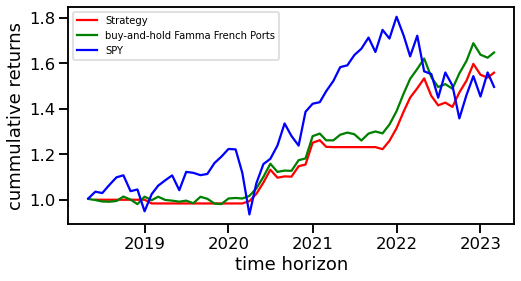

This is the cummulative returns plot for port: 2


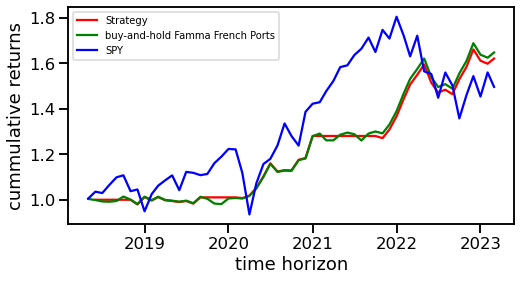

This is the cummulative returns plot for port: 3


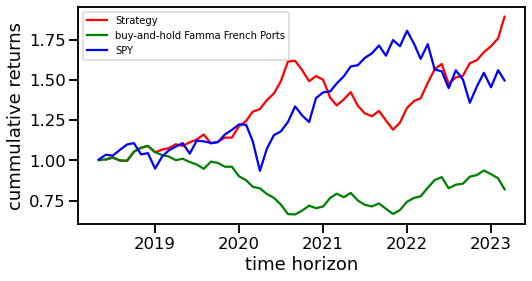

This is the cummulative returns plot for port: 4


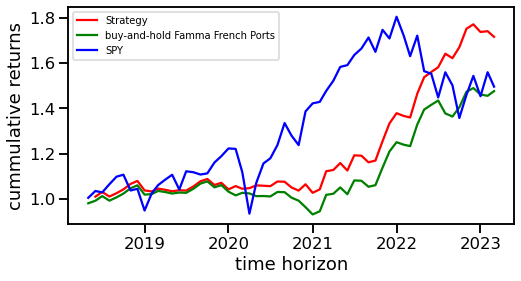

This is the cummulative returns plot for port: 5


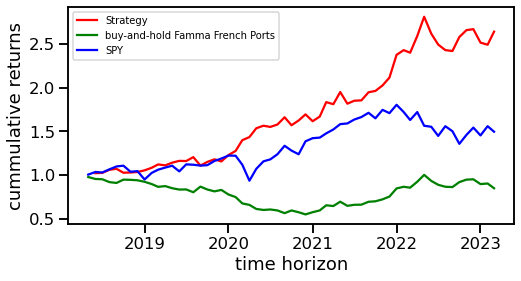

This is the cummulative returns plot for port: 6


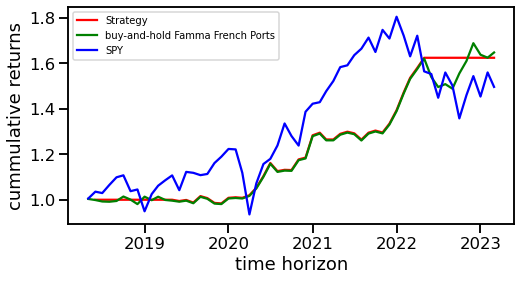

This is the cummulative returns plot for port: 7


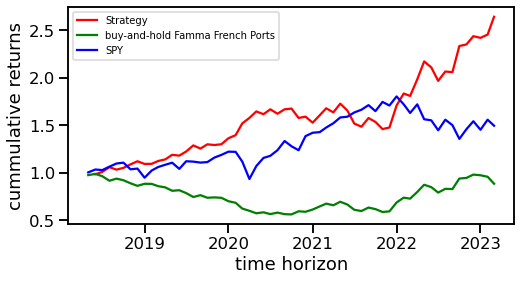

This is the cummulative returns plot for port: 8


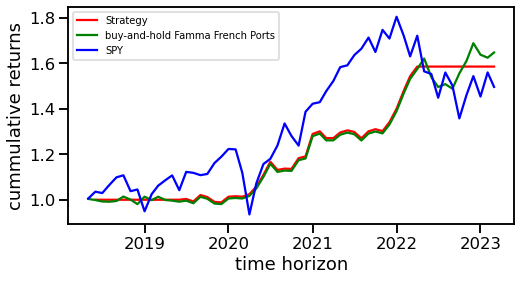

In [162]:
for count, i in enumerate([port1,port2,port3,port4,port5,port6,port7,port8]): 
    print("This is the cummulative returns plot for port:", count+1)
    plot_strat_comparision(i)

In [163]:
def key_stats_combined(df):
    df1 = df.copy()
    df2 = rfr.copy()
    df2 = df2[df2.index.isin(df1.index)]
    cum_ret = (1+df1).cumprod()
    CAGR = ((cum_ret[-1])**(12/(len(df1))))-1
    sharpe = ((df1 - df2).dropna().mean()/ (df1 - df2).dropna().std())*np.sqrt(12)
    volatility = df1.std()*np.sqrt(12)
    key = [sharpe,CAGR,volatility]
    stats = pd.DataFrame(key, index = ["Strat Sharpe","Strat CAGR","Strat Volatility"], columns = ["strat"])
    return stats

In [164]:
def combine_key_results(df):
    df1 = df.copy()
    individual_list = []
    for i in df.columns:
        individual = key_stats_combined(df1.loc[:,i])
        individual_list.append(individual)
        concat_key_results = pd.concat(individual_list, axis = 1)
    concat_key_results.columns = df.columns 

    return concat_key_results    

In [165]:
combine_key_results(combined_port_train) #train

,port1,port2,port3,port4,port5,port6,port7,port8
Strat Sharpe,0.900621,0.784569,-0.312453,-0.574203,-0.313087,0.483008,-0.235684,0.831409
Strat CAGR,0.082183,0.070702,-0.029391,-0.058607,-0.029660,0.048369,-0.015926,0.075063
Strat Volatility,0.071443,0.068228,0.126820,0.122445,0.127213,0.066130,0.115190,0.069396


In [166]:
combine_key_results(combined_port_vali)

,port1,port2,port3,port4,port5,port6,port7,port8
Strat Sharpe,-0.065994,0.100177,-0.804995,-0.395532,0.036537,-0.124270,0.222990,-2.342571
Strat CAGR,0.002986,0.004982,-0.051493,-0.022558,0.002396,-0.001271,0.018916,0.000000
Strat Volatility,0.003685,0.019736,0.067568,0.061932,0.092417,0.032473,0.088344,0.000000


In [167]:
combine_key_results(combined_port) #test

,port1,port2,port3,port4,port5,port6,port7,port8
Strat Sharpe,0.981237,1.056978,0.998629,1.105109,1.324522,1.210189,1.248254,1.153728
Strat CAGR,0.094493,0.103215,0.138432,0.116110,0.218528,0.103691,0.218601,0.098295
Strat Volatility,0.083445,0.085294,0.128625,0.092888,0.150951,0.073257,0.162665,0.072575


In [168]:
combine_key_results(combined_port).T

,Strat Sharpe,Strat CAGR,Strat Volatility
port1,0.981237,0.094493,0.083445
port2,1.056978,0.103215,0.085294
port3,0.998629,0.138432,0.128625
port4,1.105109,0.116110,0.092888
port5,1.324522,0.218528,0.150951
port6,1.210189,0.103691,0.073257
port7,1.248254,0.218601,0.162665
port8,1.153728,0.098295,0.072575


In [169]:
SMvL

1963-07-01    0.0026
1963-08-01    0.0227
1963-09-01    0.0060
1963-10-01    0.0247
1963-11-01    0.0091
               ...  
2022-11-01    0.0056
2022-12-01    0.0225
2023-01-01   -0.1382
2023-02-01    0.0305
2023-03-01    0.0167
Name: 12_1_Momentum-S-v, Length: 717, dtype: float64

In [170]:
weights = [0.2,0.2,0.05,0.05,0.1,0.1,0.1,0.2]

In [171]:
# finalist = combined_port.columns

In [172]:
finalist = ["port1","port2","port3","port4","port5","port6","port7","port8"]

In [173]:
combined_pnl = (combined_port[finalist]*weights).sum(axis = 1)
combined_pnl.head()

2018-05-01    0.000000
2018-06-01    0.001495
2018-07-01    0.004437
2018-08-01    0.006498
2018-09-01   -0.000752
dtype: float64

In [174]:
combined_pnl_vali = (combined_port_vali[finalist]*weights).sum(axis = 1)
combined_pnl_vali.head()

2013-05-01    0.000000
2013-06-01    0.000142
2013-07-01    0.000622
2013-08-01   -0.004364
2013-09-01   -0.002956
dtype: float64

In [175]:
key_stats_combined(combined_pnl_vali)

,strat
Strat Sharpe,-0.128580
Strat CAGR,0.000718
Strat Volatility,0.018229


In [176]:
key_stats_combined(combined_pnl)

,strat
Strat Sharpe,1.638909
Strat CAGR,0.128373
Strat Volatility,0.066568


In [177]:
BnH_results_test.head(1)

,BnH Sharpe,BnH CAGR,BnH Volatility
Investment-S-e,1.032395,0.106889,0.089197


In [178]:
BnH_combined = pd.concat([BMv, BMe, CPv, CPe, DPv, DPe, EPv, EPe, OPv, OPe, INv, INe, PRv, PRe, SMv, SMe, LMv, LMe], axis = 1).loc["2018-05-01":]

In [179]:
BnH_combined.head()

,Book_to_Market-B-v,Book_to_Market-S-v,Book_to_Market-B-e,Book_to_Market-S-e,Cashflow_to_Price-B-v,Cashflow_to_Price-S-v,Cashflow_to_Price-B-e,Cashflow_to_Price-S-e,Dividend_Yield-B-v,Dividend_Yield-S-v,...,Prior_Month_Return-B-e,Prior_Month_Return-S-e,12_1_Momentum-B-v,12_1_Momentum-S-v,12_1_Momentum-B-e,12_1_Momentum-S-e,60_13_Momentum-B-v,60_13_Momentum-S-v,60_13_Momentum-B-e,60_13_Momentum-S-e
2018-05-01,-0.041027,-0.022589,-0.018298,-0.040766,-0.0161,-0.0179,-0.0259,-0.0036,0.0009,0.0011,...,0.0065,0.0078,0.0433,0.0344,0.0433,0.0273,-0.0238,0.0192,0.0020,0.0011
2018-06-01,-0.023971,-0.022635,-0.022299,-0.006764,-0.0148,0.0192,-0.0018,0.0117,0.0061,0.0108,...,0.0130,-0.0015,-0.0344,-0.0127,-0.0358,0.0043,0.0135,0.0049,0.0140,-0.0086
2018-07-01,0.012741,-0.003348,-0.004728,0.006928,0.0012,-0.0074,-0.0029,-0.0070,0.0119,-0.0009,...,0.0239,-0.0120,-0.0290,0.0008,-0.0107,0.0243,-0.0248,-0.0062,-0.0158,-0.0224
2018-08-01,-0.045168,-0.034392,-0.040660,-0.051972,-0.0305,-0.0329,-0.0455,-0.0208,-0.0181,-0.0189,...,0.0162,0.0130,0.0691,0.0367,0.0505,0.0431,-0.0495,-0.0064,-0.0253,-0.0075
2018-09-01,-0.023379,-0.010505,-0.015983,-0.018417,-0.0093,0.0012,-0.0079,-0.0021,-0.0021,0.0079,...,-0.0104,-0.0110,0.0049,-0.0042,-0.0042,-0.0030,0.0243,0.0127,0.0074,0.0137


In [180]:
naive1 = BnH_combined.mean(axis =1)

In [181]:
key_stats_combined(naive1)
#if you take the most naive approach to equal weight all the buy-and-hold

,strat
Strat Sharpe,0.065020
Strat CAGR,0.015341
Strat Volatility,0.070795


In [182]:
naive2 = ((DPvH + INeL + OPeH + BMvL + LMvH)/5).loc["2018-05-01":]

In [183]:
key_stats_combined((naive2))
#if you just equal weight buy and hold the two portfolios we traded on 

,strat
Strat Sharpe,0.123778
Strat CAGR,0.020884
Strat Volatility,0.100423


In [184]:
SPY_ret

Date
1993-02-01   -0.001152
1993-03-01   -0.001152
1993-04-01    0.018755
1993-05-01   -0.022452
1993-06-01    0.030987
                ...   
2022-11-01    0.075435
2022-12-01    0.057174
2023-01-01   -0.058154
2023-02-01    0.072851
2023-03-01   -0.040741
Name: Close, Length: 362, dtype: float64

In [185]:
def key_stats_combined_v2(df):
    df1 = df.copy()
    df2 = rfr.copy()
    df3 = SPY_ret.copy()
    df2 = df2[df2.index.isin(df1.index)]
    df3 = df3[df3.index.isin(df1.index)]
    cum_ret = (1+df1).cumprod()
    CAGR = ((cum_ret[-1])**(12/(len(df1))))-1
    sharpe = ((df1 - df2).dropna().mean()/ (df1 - df2).dropna().std())*np.sqrt(12)
    volatility = df1.std()*np.sqrt(12)
    
    #sortino ratio calculation
    excess_ret = df1 - df3
    mean_excess = (excess_ret).mean()
    below_target_semi_variance = (excess_ret).\
                                  apply(lambda x: (np.minimum(x,0))**2).mean()

    sortino = (mean_excess/np.sqrt(below_target_semi_variance))*np.sqrt(12)
    
    #omega ratio calculation
    PositiveSum = excess_ret[excess_ret>0].sum()
    NegativeSum = excess_ret[excess_ret<0].sum()
    omega = (PositiveSum / (-NegativeSum))
    
    key = [sharpe,CAGR,volatility,sortino,omega]
    stats = pd.DataFrame(key, index = ["Strat Sharpe","Strat CAGR","Strat Volatility","Strat Sortino Ratio","Strat Omega Ratio"], columns = ["strat"])
    return stats

In [186]:
def combine_key_results_v2(df):
    df1 = df.copy()
    individual_list = []
    for i in df.columns:
        individual = key_stats_combined_v2(df1.loc[:,i])
        individual_list.append(individual)
        concat_key_results = pd.concat(individual_list, axis = 1)
    concat_key_results.columns = df.columns 

    return concat_key_results    

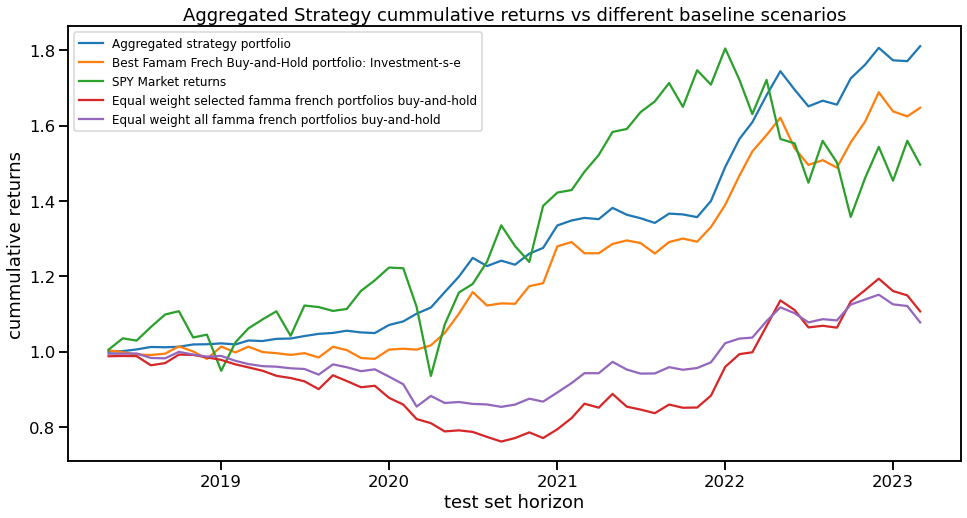

In [187]:
plt.figure(figsize = (16,8))
plt.plot(combined_pnl.index, (1+combined_pnl).cumprod(), label = "Aggregated strategy portfolio")
plt.plot(INeL.loc["2018-05-01":].index, (1+INeL.loc["2018-05-01":]).cumprod(), label = "Best Famam Frech Buy-and-Hold portfolio: Investment-s-e")
plt.plot(SPY_ret.loc["2018-05-01":].index, (1+SPY_ret.loc["2018-05-01":]).cumprod(), label = "SPY Market returns")
plt.plot(naive2.index, (1+(naive2)).cumprod(), label = "Equal weight selected famma french portfolios buy-and-hold")
plt.plot(naive1.index, (1+(naive1)).cumprod(), label = "Equal weight all famma french portfolios buy-and-hold")

plt.title("Aggregated Strategy cummulative returns vs different baseline scenarios")
plt.xlabel("test set horizon")
plt.ylabel("cummulative returns")
plt.legend(fontsize = 12)

In [188]:
final_compare_list = []
for i in [combined_pnl,INeL.loc["2018-05-01":],SPY_ret.loc["2018-05-01":],naive2,naive1]:
    final_compare = key_stats_combined(i)
    final_compare_list.append(final_compare)
    final_compare_df = pd.concat(final_compare_list, axis = 1)
final_compare_df.columns = ["Aggregated strategy Port","basecase 1","basecase 2: SPY","basecase 3", "basecase 4"]  
final_compare_df

,Aggregated strategy Port,basecase 1,basecase 2: SPY,basecase 3,basecase 4
Strat Sharpe,1.638909,1.032395,0.445936,0.123778,0.065020
Strat CAGR,0.128373,0.106889,0.085410,0.020884,0.015341
Strat Volatility,0.066568,0.089197,0.199206,0.100423,0.070795


In [189]:
final_compare_list = []
for i in [combined_pnl,INeL.loc["2018-05-01":],SPY_ret.loc["2018-05-01":],naive2,naive1]:
    final_compare = key_stats_combined_v2(i)
    final_compare_list.append(final_compare)
    final_compare_df = pd.concat(final_compare_list, axis = 1)
final_compare_df.columns = ["Aggregated strategy Port","basecase 1","basecase 2: SPY","basecase 3", "basecase 4"]  
final_compare_df

,Aggregated strategy Port,basecase 1,basecase 2: SPY,basecase 3,basecase 4
Strat Sharpe,1.638909,1.032395,0.445936,0.123778,0.065020
Strat CAGR,0.128373,0.106889,0.085410,0.020884,0.015341
Strat Volatility,0.066568,0.089197,0.199206,0.100423,0.070795
Strat Sortino Ratio,0.172603,0.028377,NaN,-0.472169,-0.554703
Strat Omega Ratio,1.081901,1.013276,NaN,0.775346,0.736226


In [190]:
# shimiao = pd.read_csv("pnl_Shimiao.csv").set_index("Unnamed: 0").rename_axis(index = "Date")
# shimiao = shimiao.loc[:,"0"]
# shimiao.index = pd.to_datetime(shimiao.index)
# shimiao = pd.to_numeric(shimiao)
# shimiao.index = shimiao.index.apply(lambda x: datetine.strptime(x, "%Y/%m/%d"))

In [191]:
shimiao = pd.read_csv("pnl_Shimiao.csv")
shimiao.columns = ["Date", "ret"]
shimiao["Date"] = pd.to_datetime(shimiao["Date"]).dt.strftime("%Y-%d-%m")
shimiao.set_index("Date", inplace = True)
shimiao = shimiao.loc[:,"ret"]
shimiao.head()

Date
2018-05-01    0.010894
2018-06-01    0.011353
2018-07-01    0.009788
2018-08-01    0.021081
2018-09-01    0.001189
Name: ret, dtype: float64

In [192]:
shimiao.index = pd.to_datetime(shimiao.index)
shimiao.index

DatetimeIndex(['2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
      

In [193]:
len(shimiao)

59

In [194]:
len(combined_pnl)

59

In [195]:
combined_pnl.corr(shimiao)

0.16437243484007144

In [196]:
key_stats_combined((combined_pnl + shimiao)/2)

,strat
Strat Sharpe,2.067710
Strat CAGR,0.112127
Strat Volatility,0.045173


In [197]:
combined_pnl.to_csv("cedricPnL.csv", index=False)

In [198]:
INeL.name

'Investment-S-e'

In [199]:
# new_ports = [BMvH,BMvL,BMeH,BMeL,CPvH,CPvL,CPeH,CPeL,DPvH,DPvL,\
#              DPeH,DPeL,EPvH,EPvL,EPeH,EPeL,OPvH,OPvL,OPeH,OPeL,\
#              INvH,INvL,INeH,INeL,PRvH,PRvL,PReH,PReL,SMvH,SMvL,\
#              SMeH,SMeL,LMvH,LMvL,LMeH,LMeL]

In [200]:
def getmarkovclasstable(regress_inst,trade_inst,start, test_start):
    df1 = regress_inst.copy() #regimes are classified based on this underlying instrument
    df1 = df1.loc[start:]
    df2 = trade_inst.copy() #this is the trading instrument used to 
    df2 = df2.loc[start:]

    model = MarkovRegression(df1, k_regimes=2, switching_variance=True).fit()
    regime = model.smoothed_marginal_probabilities.values.argmax(axis=1)
    
    df2 = df2.loc[test_start:]
    
    frame = pd.DataFrame(regime, index = df1.index, columns = ["State"])
    frame = frame.loc[test_start:]
    regimeclasses = frame.iloc[:-1] 
    
    actual_ret = df2.shift(-1).dropna()

    actual_ret = np.sign(actual_ret).replace([1,-1], [0,1])
    
    print(classification_report(actual_ret,regimeclasses))
    print(regimeclasses.value_counts())

In [201]:
# portfolios = [BMv, BMe, CPv, CPe, DPv, DPe, EPv, EPe, OPv, OPe, INv, INe, PRv, PRe, SMv, SMe, LMv, LMe]

In [202]:
getmarkovclasstable(SMvL,DPvH,"1998-07-01","2018-05-01")

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69        27
         1.0       0.73      0.71      0.72        31

    accuracy                           0.71        58
   macro avg       0.71      0.71      0.71        58
weighted avg       0.71      0.71      0.71        58

State
1        30
0        28
dtype: int64


In [203]:
getmarkovclasstable(PReL,OPeH,"1998-07-01","2018-05-01")

              precision    recall  f1-score   support

         0.0       0.61      0.91      0.73        33
         1.0       0.67      0.24      0.35        25

    accuracy                           0.62        58
   macro avg       0.64      0.57      0.54        58
weighted avg       0.64      0.62      0.57        58

State
0        49
1         9
dtype: int64


In [204]:
getmarkovclasstable(DFF,BMvL,"1998-07-01","2018-05-01")

              precision    recall  f1-score   support

         0.0       0.67      0.64      0.65        25
         1.0       0.74      0.76      0.75        33

    accuracy                           0.71        58
   macro avg       0.70      0.70      0.70        58
weighted avg       0.71      0.71      0.71        58

State
1        34
0        24
dtype: int64


In [205]:
getmarkovclasstable(DFF,LMvH,"1998-07-01","2018-05-01")

              precision    recall  f1-score   support

         0.0       0.54      0.57      0.55        23
         1.0       0.71      0.69      0.70        35

    accuracy                           0.64        58
   macro avg       0.62      0.63      0.62        58
weighted avg       0.64      0.64      0.64        58

State
1        34
0        24
dtype: int64


# <font color = "green"> End of presentation

In [ ]:
hello